In [1]:
from pickle import load
from functools import partial
import healpy as hp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from chainconsumer import ChainConsumer

import src.forward_model as FM
import src.beam_functions as BF
import src.sky_models as SM
from src.spherical_harmonics import RealSphericalHarmonics, calc_spherical_harmonic_matrix
from src.nregions_models import pix_forward_model_pl, genopt_pix_forward_model_pl
from src.blockmat import BlockMatrix, BlockVector
RS = RealSphericalHarmonics()
from nregions_inference import nuarr
import nregions_inference as NRI

from chainconsumer import ChainConsumer
from emcee import EnsembleSampler

In [13]:
saveloc = "Nregs_pl_gsmalo/"


def load_chain(savename, burn_in=5000, thin=1, end=-1, suffix='_1'):
    """
    Load the chain, burning in, thinning and flattening.
    """
    chain = np.load(f"saves/{saveloc}"+savename+suffix+".npy")
    print("Loaded chain of orginal shape", chain.shape)
    chain = chain[burn_in:end:thin]
    ch_sh = np.shape(chain)
    chain_flat = np.reshape(chain, (ch_sh[0]*ch_sh[1], ch_sh[2]))  # Flatten chain.
    return chain_flat


def param_estimator(chain, stats="mean"):
    if stats=="mean":
        theta_est = np.mean(chain, axis=0)
    elif stats=="max":
        c = ChainConsumer()
        c.add_chain(chain, statistics=stats)
        analysis_dict = c.analysis.get_summary(squeeze=True)
        theta_est = np.array([val[1] for val in analysis_dict.values()])
    return theta_est


def plot_chain(*chains, stats=None, walks=False):
    """
    Plot the corner figure of the foreground inference.
    """
    c=ChainConsumer()
    params = [r'$\gamma_{n}$'.replace('n', str(n)) for n in range(1, Nreg+1)]
    
    for chain in chains:
        c.add_chain(chain, parameters=params)
        print("Plotting chain of shape", chain.shape)
    if walks:
        c.plotter.plot_walks()
    elif not walks:
        c.plotter.plot()
    plt.show()


def showcase_model_residuals(chain, Nreg, savename, stats="mean"):
    # Generate most-likely data.
    theta_est = param_estimator(chain, stats)

    # Load the observation parameters and instantiate the inferred model.
    with open(f"saves/{saveloc}{savename}_pars.pkl", 'rb') as f:
        pars = load(f)
    model = NRI.main(return_model=True, Nregions=Nreg, times=pars["times"], lmax=pars["lmax"], nside=pars["nside"])
    if "unoise" in savename:
        noise = pars['unoise']
    elif "radnoise" in savename:
        raise NotImplementedError
    model_temps = model(theta=theta_est)
    
    data = np.load(f"saves/{saveloc}{savename}_data.npy")
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    ax[0].plot(data, '.', label='data')
    ax[0].plot(model_temps, '.', label='model')
    ax[1].errorbar(range(len(data)), data-model_temps, yerr=noise, fmt='.')
    ax[0].set_xlabel('bin')
    ax[1].set_xlabel('bin')
    ax[0].set_ylabel('Temperature [K]')
    ax[1].set_ylabel('Temperature residuals [K]')
    ax[0].legend()
    fig.tight_layout()
    fig.show()


def visualise_fgs(chain, Nreg, stats="mean", nside=16):
    theta_est = param_estimator(chain, stats=stats)
    indx = np.load(f"anstey/indexes_{nside}.npy")
    
    mask_maps, _ = NRI.mask_split(Nregions=Nreg, nside=nside)
    fidmap = SM.foreground_gsma_nsidelo(60, nside=nside)
    
    hp.mollview(np.split(pix_forward_model_pl(powers=theta_est, nuarr=nuarr, base_map=indx[0], masks=mask_maps), 51)[10], title='model estimate')
    plt.show()
    
    hp.mollview(fidmap, title='fiducial sky')
    plt.show()
    hp.mollview(np.abs(fidmap-np.split(pix_forward_model_pl(powers=theta_est, nuarr=nuarr, base_map=indx[0], masks=mask_maps), 51)[10]), title='|fiducial-model|')
    plt.show()
    sns.histplot(fidmap-np.split(pix_forward_model_pl(powers=theta_est, nuarr=nuarr, base_map=indx[0], masks=mask_maps), 51)[10], bins=50)
    plt.show()

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


calc_spherical_harmonic_matrix npix, nalm : 3072 561


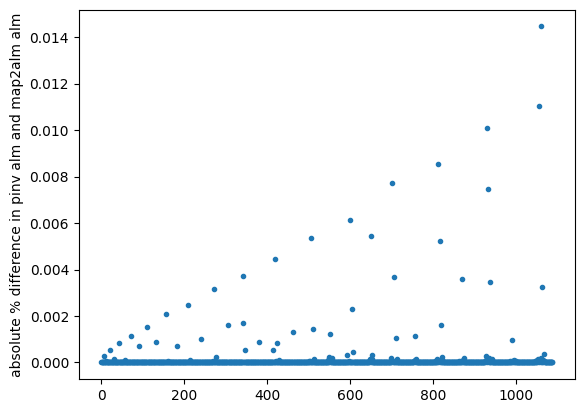

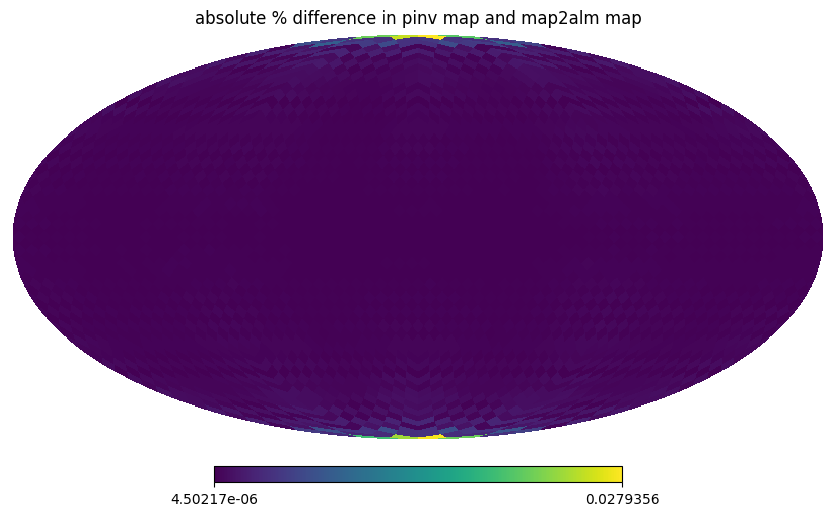

In [2]:
# Compare Y^-1 = pinv(mat_Y) vs. hp.map2alm
skymap = SM.foreground_gsma_nsidelo(nu=60)

# Y^-1
mat_Y = calc_spherical_harmonic_matrix(nside=16, lmax=32)
pinv_mat_Y = np.linalg.pinv(mat_Y)
pinv_alm = pinv_mat_Y@skymap

# hp.map2alm
map2alm_alm = hp.map2alm(skymap, lmax=32)
map2alm_alm = RS.complex2RealALM(map2alm_alm)

# Plot the difference.
plt.plot(np.abs((pinv_alm-map2alm_alm)/map2alm_alm)*100, '.')
plt.ylabel("absolute % difference in pinv alm and map2alm alm")
plt.show()

# Transform back to pixel space in the same way to compare temperature error magnitudes.
pinv_skymap = mat_Y@pinv_alm
map2alm_skymap = mat_Y@map2alm_alm
reconstruction_err = np.abs((pinv_skymap-map2alm_skymap)/map2alm_skymap)*100
hp.mollview(reconstruction_err, title="absolute % difference in pinv map and map2alm map")

In [3]:
# Do we have to worry about this error scale?
# Find the indexes of percentage errors greater than 0.02%
bad_flag = np.where(reconstruction_err>0.02, True, False)
bad_idx = [i for i, flag in enumerate(bad_flag) if flag]

# See how hot those pixels are in the original map.
print("Pix in map are", *skymap[bad_idx], "K")
print("so reconstruction error is", *skymap[bad_idx]*reconstruction_err[bad_idx]/100, "K")

Pix in map are 3415.3919513767423 3198.633680327801 3289.5360090249314 3348.544555038561 3599.2956330083675 3465.8106416624314 3375.0213233516874 K
so reconstruction error is 0.8689637986535486 0.6943055770020127 0.6794620313507836 0.9354367386672676 0.860537981527261 0.7471253437384924 0.9303478492590318 K


## Does the pixel-space model faithfully represent the fiducial pixel map?

In [11]:
def visualise_fgs_1(chain, Nreg, fidmap):
    nside = hp.npix2nside(len(fidmap))
    indx = np.load(f"anstey/indexes_{nside}.npy")
    theta_est = np.mean(chain, axis=0)
    
    mask_maps, _ = NRI.mask_split(Nregions=Nreg, nside=nside)
    mod_est = pix_forward_model_pl(powers=theta_est, nuarr=[60], base_map=indx[0], masks=mask_maps).flatten()
    hp.mollview(mod_est, title='model estimate')
    plt.show()

    hp.mollview(fidmap, title='fiducial sky')
    plt.show()
    hp.mollview(np.abs(fidmap-mod_est), title='|fiducial-model|')
    plt.show()
    sns.histplot(fidmap-mod_est, bins=50)
    plt.show()

## See how well these "optimal" parameters compare to the inference from observations.
### First do pixel-wise inference

In [75]:
# Generate the fiducial map and noise.
fidmap60, basemap = SM.foreground_gsma_nsidelo(nu=[60, 408])
noise = np.ones(len(fidmap60))*10.
data = fidmap60

# Set up the forward model.
Nreg = 9
mask_maps, inference_boundguess = NRI.mask_split(Nregions=Nreg)
model = partial(pix_forward_model_pl, nuarr=[60], base_map=basemap, masks=mask_maps)

# Set up the inference.
steps = 10000
nwalkers = 32
p0 = np.mean(inference_boundguess, axis=1)
pos = p0*(1 + 1e-4*np.random.randn(nwalkers, Nreg))
priors = [[0.5, 5.0]]*Nreg
priors = np.array(priors)
sampler = EnsembleSampler(nwalkers, Nreg, NRI.log_posterior, 
                    args=(data, noise, model, priors))
_=sampler.run_mcmc(pos, steps, progress=True)

100%|█████████████████████████████████████| 10000/10000 [01:47<00:00, 93.43it/s]


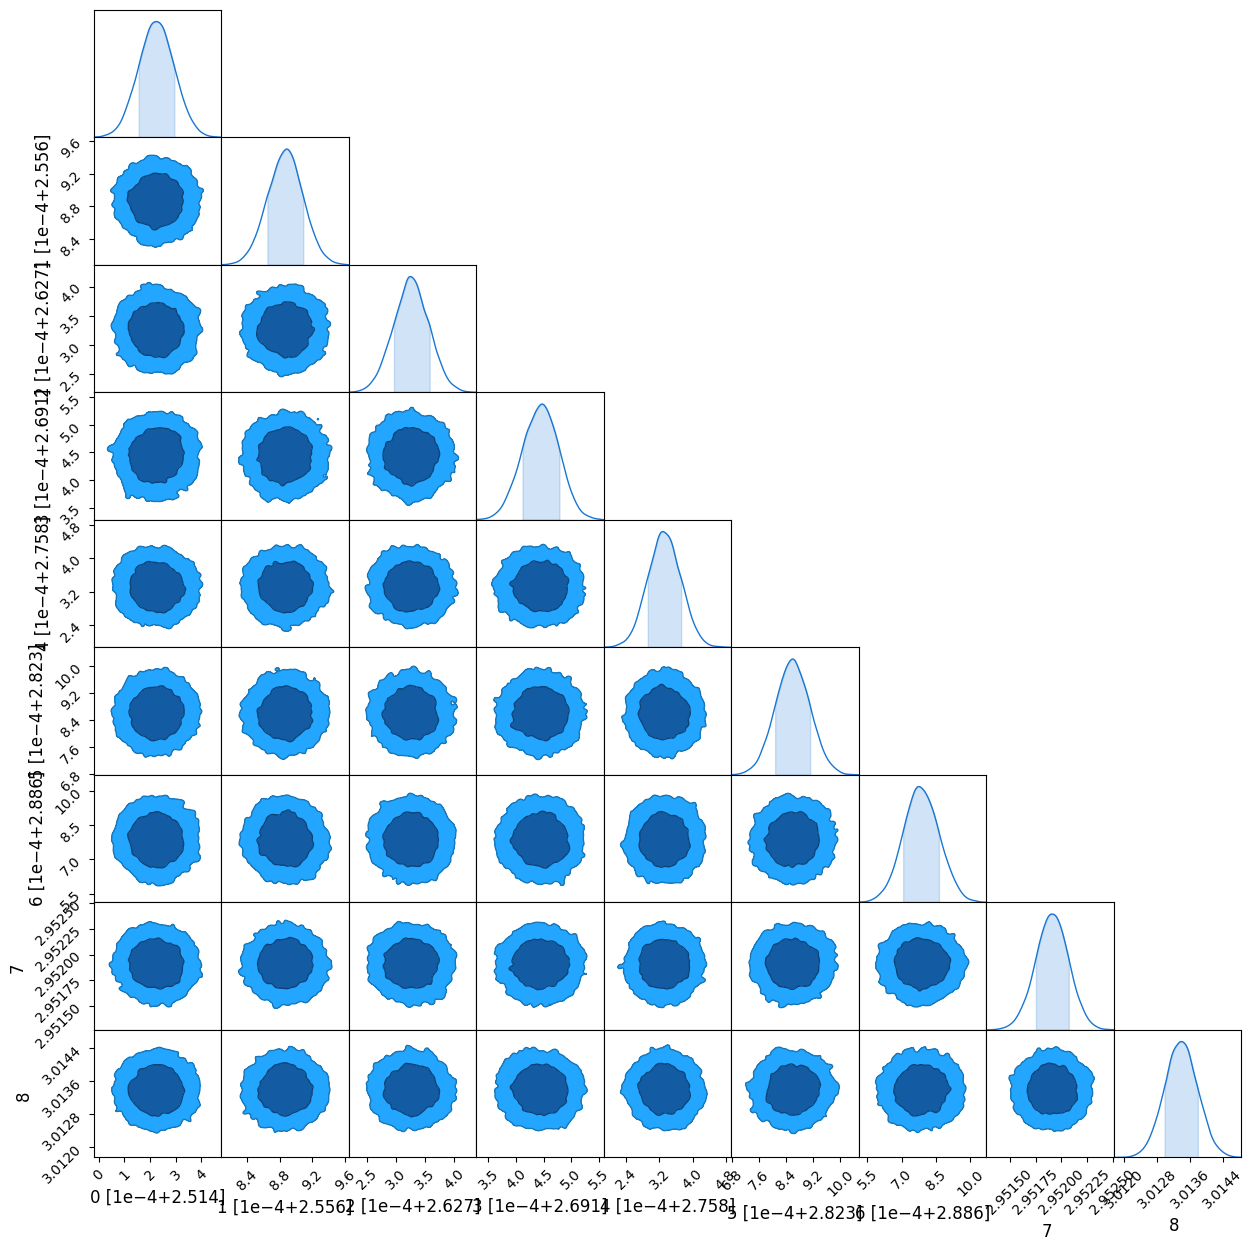

In [76]:
chain = sampler.get_chain(flat=True)
c = ChainConsumer()
chain = chain[200000:]
c.add_chain(chain)
_=c.plotter.plot()

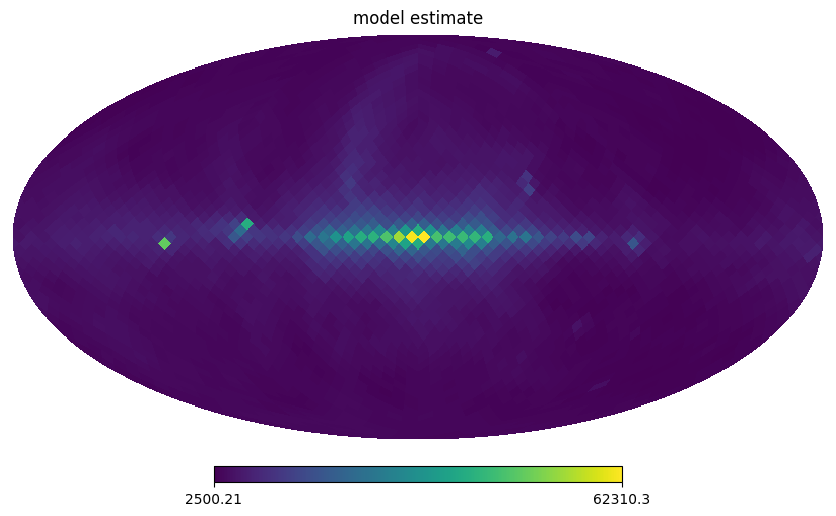

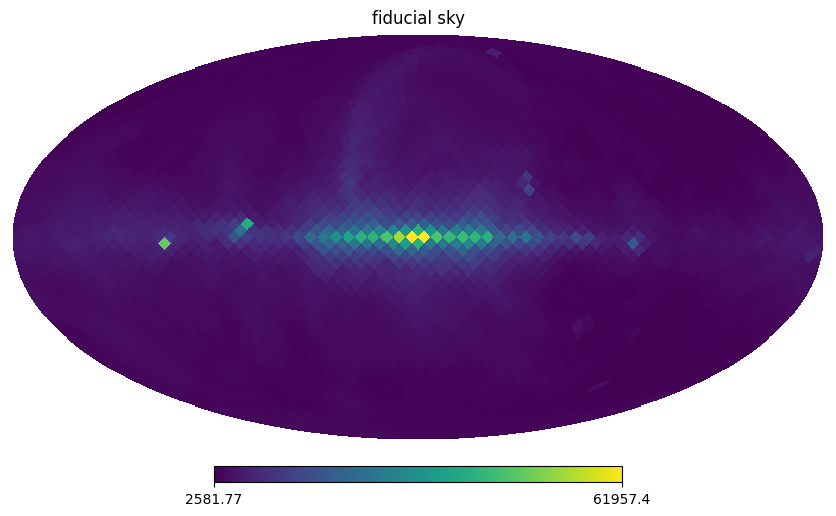

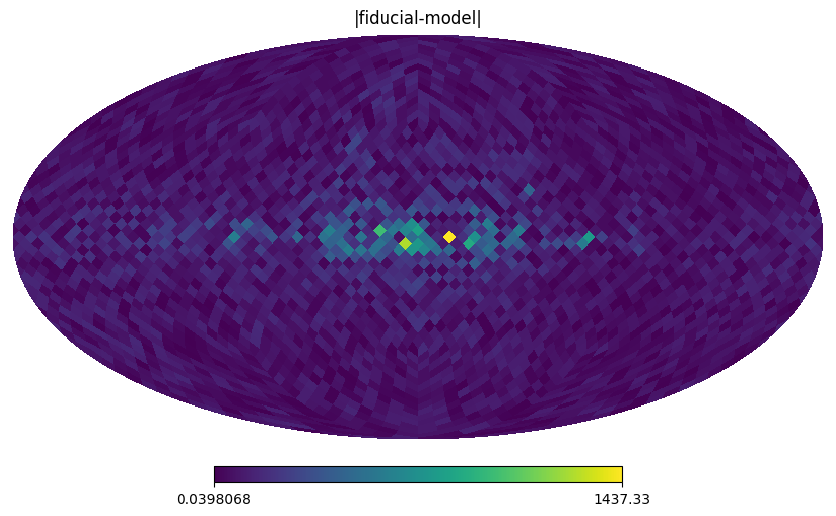

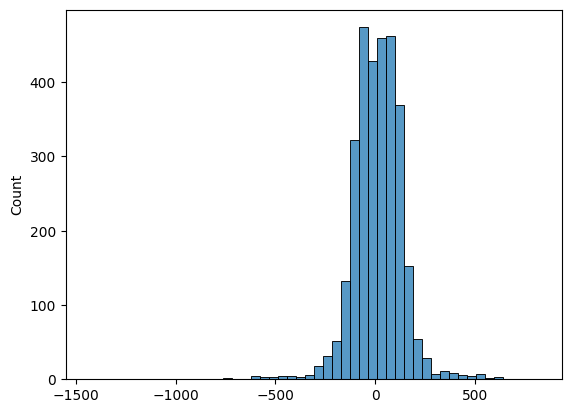

In [26]:
visualise_fgs_1(chain, Nreg, fidmap60)

### Now load and compare some "standard" inference

Loaded chain of orginal shape (1000000, 32, 9)
Plotting chain of shape (304000, 9)
Plotting chain of shape (120000, 9)


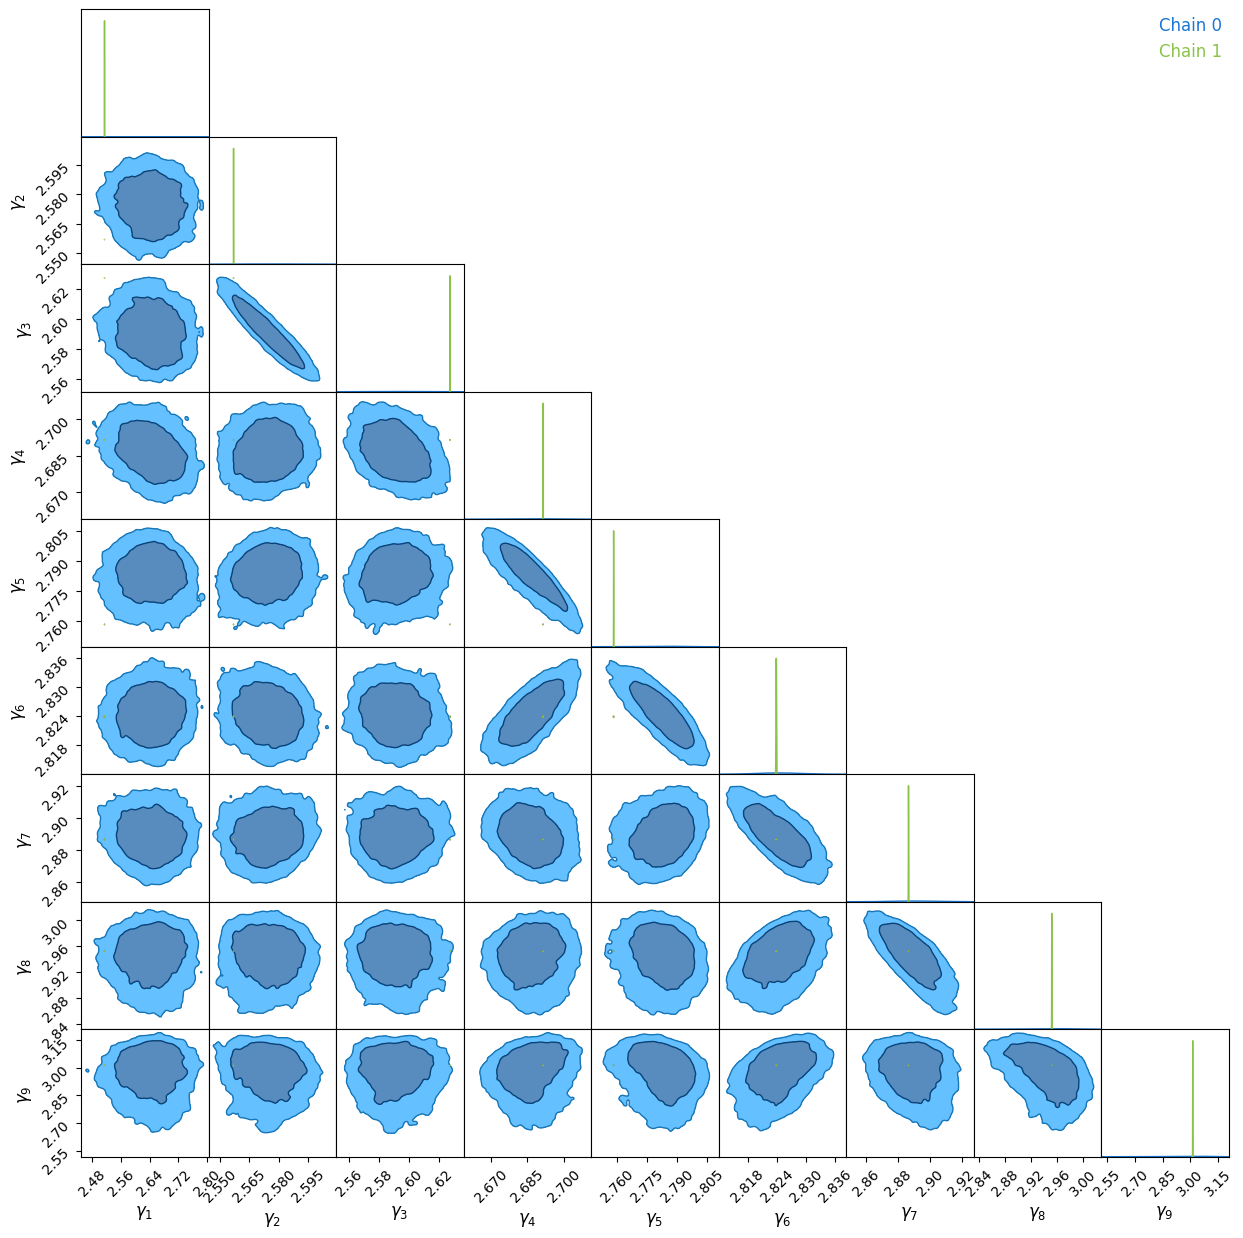

In [92]:
Nreg = 9
savename = f"{Nreg}reg_unoise_GSMA"
chain_g = load_chain(savename, burn_in=50000, thin=100, end=-1, suffix="_2")
plot_chain(chain_g, chain, walks=False)

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


calc_spherical_harmonic_matrix npix, nalm : 3072 561


/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_16076/198953934.py:66: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


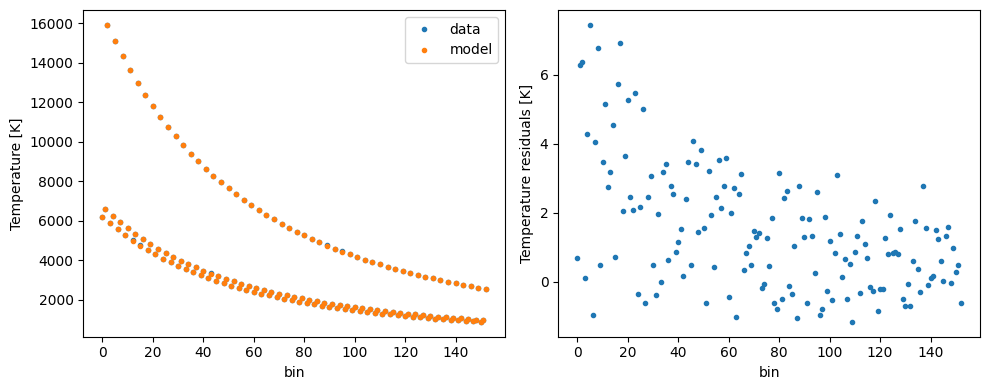

In [95]:
showcase_model_residuals(chain_g, Nreg, savename, stats='mean')

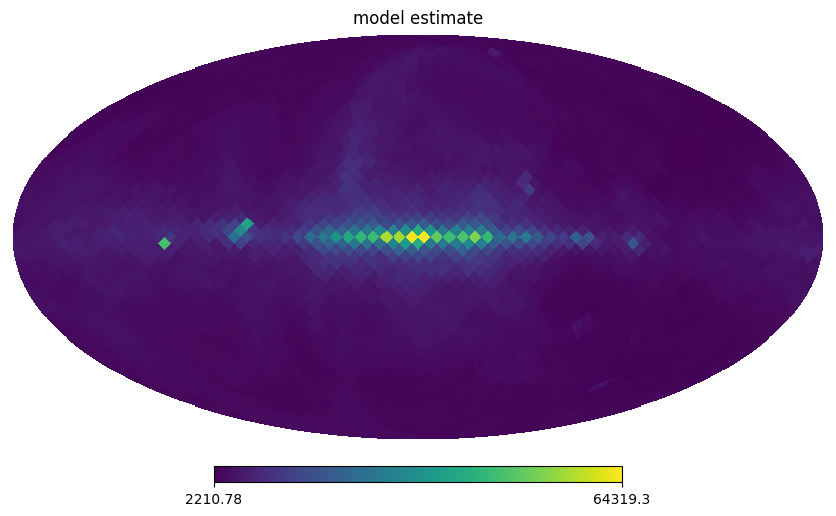

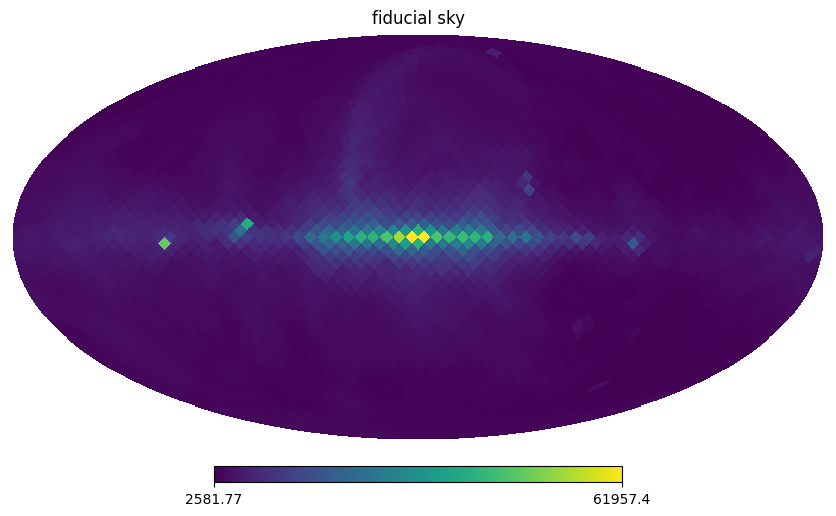

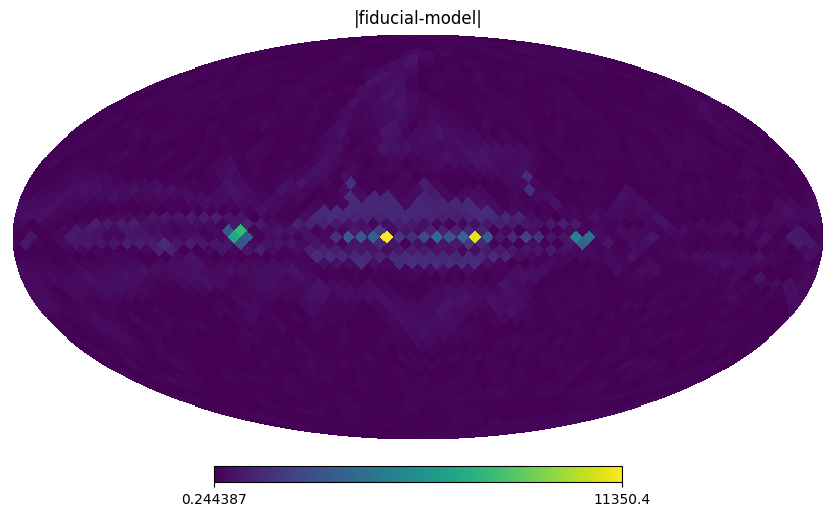

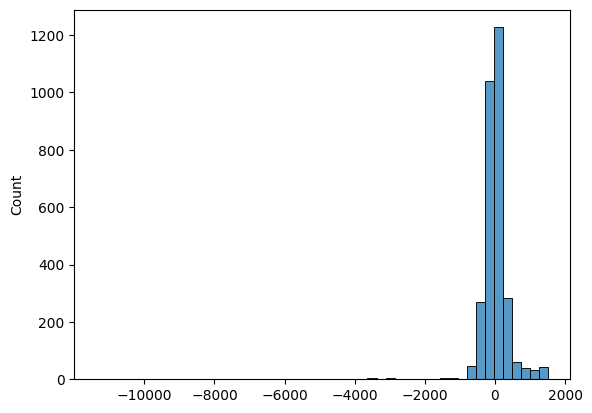

In [94]:
visualise_fgs_1(chain_g, Nreg, fidmap60)

In [63]:
# Generate the fiducial map and noise.
fidmap60, basemap = SM.foreground_gsma_nsidelo(nu=[60, 408])
noise = np.ones(len(fidmap60))*1.
data = fidmap60

# Set up the forward model.
Nreg = 12
mask_maps, inference_boundguess = NRI.mask_split(Nregions=Nreg)
model = partial(pix_forward_model_pl, nuarr=[60], base_map=basemap, masks=mask_maps)

# Set up the inference.
steps = 10000
nwalkers = 32
p0 = np.mean(chain, axis=0)
pos = p0*(1 + 1e-4*np.random.randn(nwalkers, Nreg))
priors = [[0.5, 5.0]]*Nreg
priors = np.array(priors)
sampler = EnsembleSampler(nwalkers, Nreg, NRI.log_posterior, 
                    args=(data, noise, model, priors))
_=sampler.run_mcmc(pos, steps, progress=True)

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]
100%|█████████████████████████████████████| 10000/10000 [02:20<00:00, 71.28it/s]


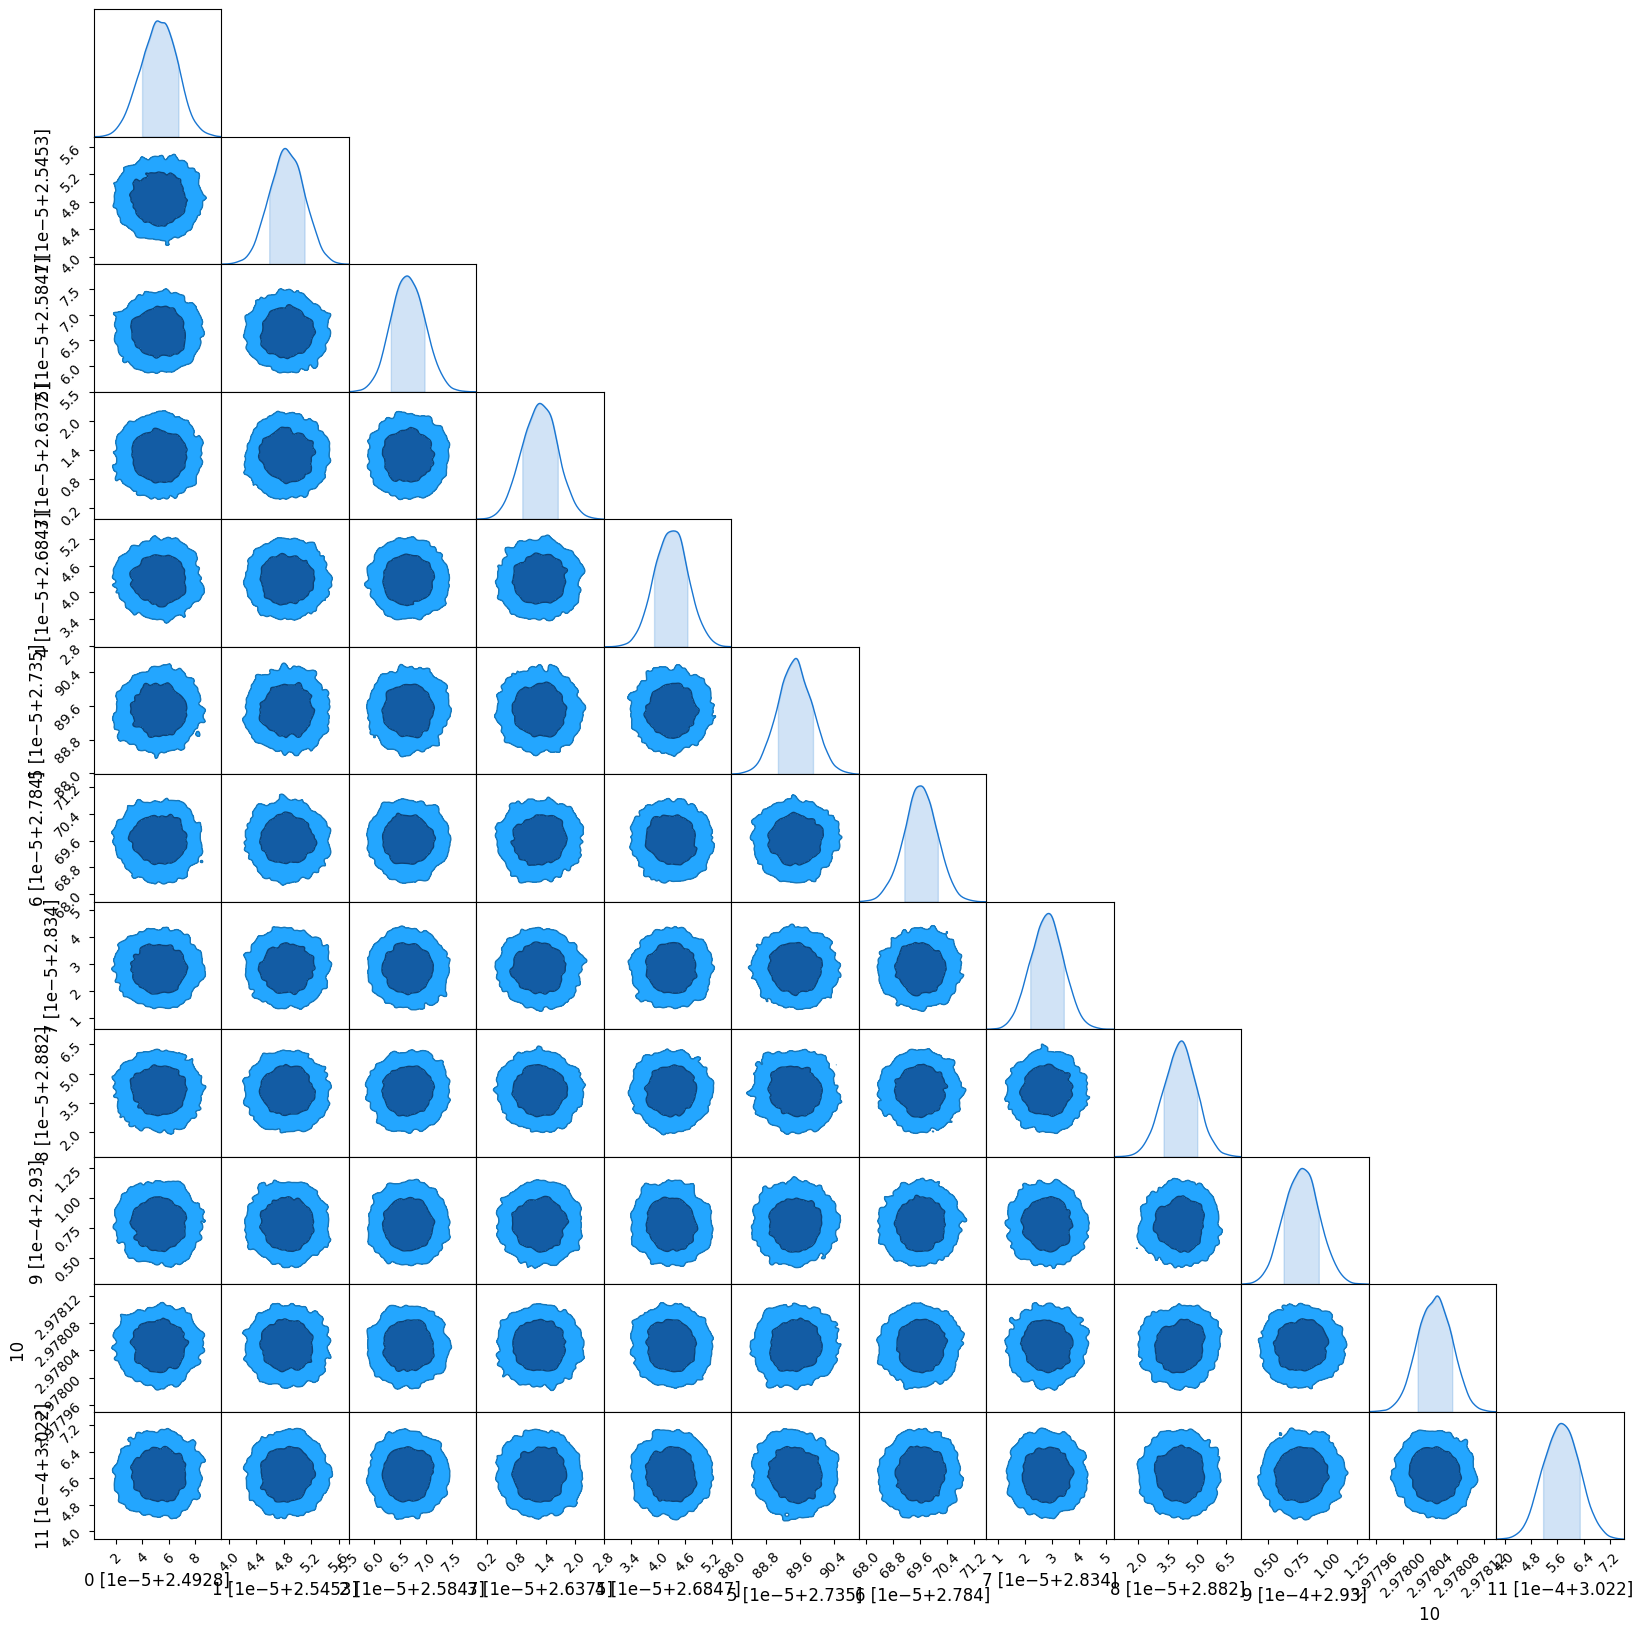

In [66]:
chain = sampler.get_chain(flat=True)
c = ChainConsumer()
chain = chain[200000:]
c.add_chain(chain)
_=c.plotter.plot()

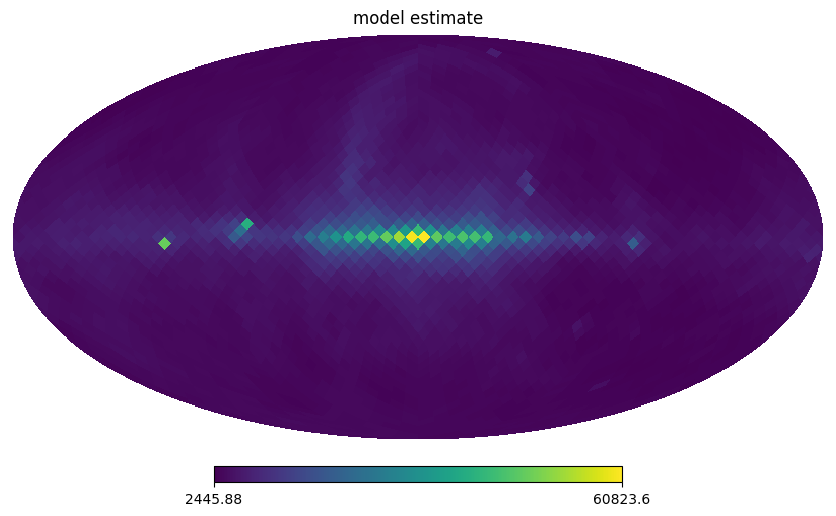

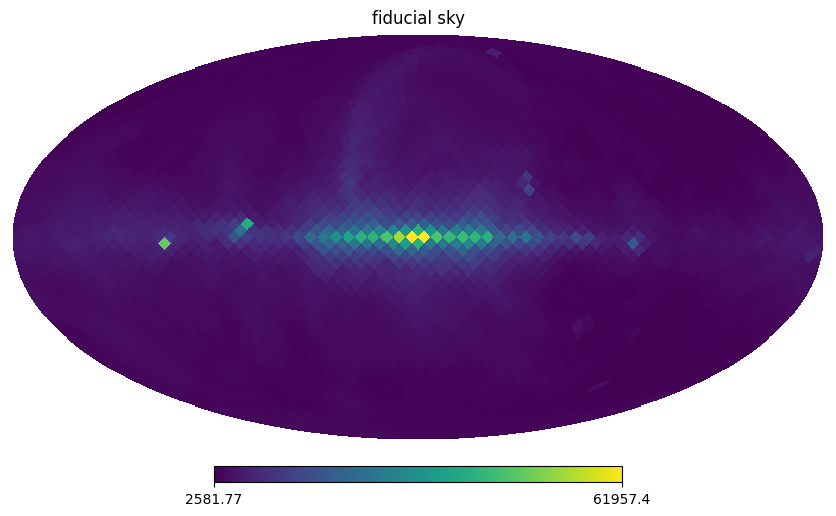

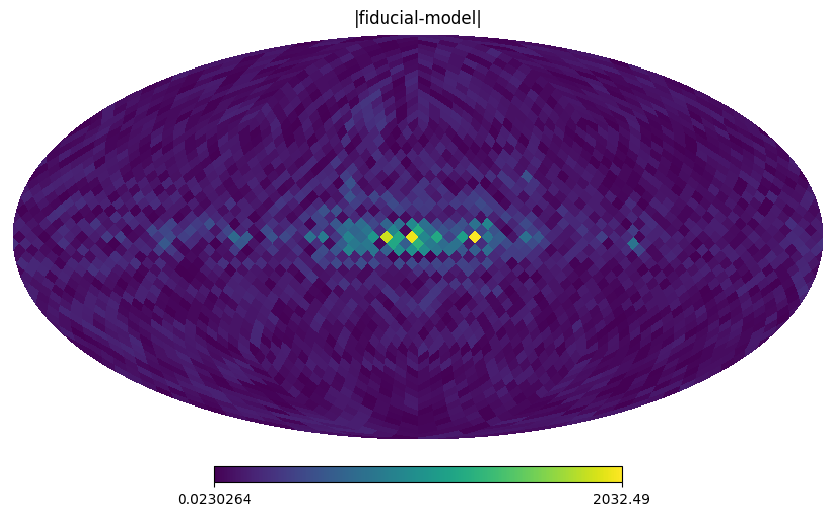

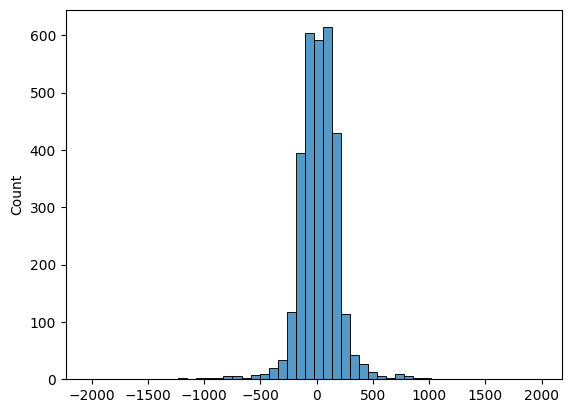

In [67]:
visualise_fgs(chain, Nreg, fidmap60)

In [18]:
# Generate the fiducial map and noise.
fidmap60, basemap = SM.foreground_gsma_nsidelo(nu=[60, 408])
noise = np.ones(len(fidmap60))*100.
data = fidmap60

# Set up the forward model.
Nreg = 16
mask_maps, inference_boundguess = NRI.mask_split(Nregions=Nreg)
model = partial(pix_forward_model_pl, nuarr=[60], base_map=basemap, masks=mask_maps)

# Set up the inference.
steps = 10000
nwalkers = 32
p0 = np.mean(inference_boundguess, axis=1)
pos = p0*(1 + 1e-4*np.random.randn(nwalkers, Nreg))
priors = [[0.5, 5.0]]*Nreg
priors = np.array(priors)
sampler = EnsembleSampler(nwalkers, Nreg, NRI.log_posterior, 
                    args=(data, noise, model, priors))
_=sampler.run_mcmc(pos, steps, progress=True)

100%|█████████████████████████████████████| 10000/10000 [01:41<00:00, 98.92it/s]


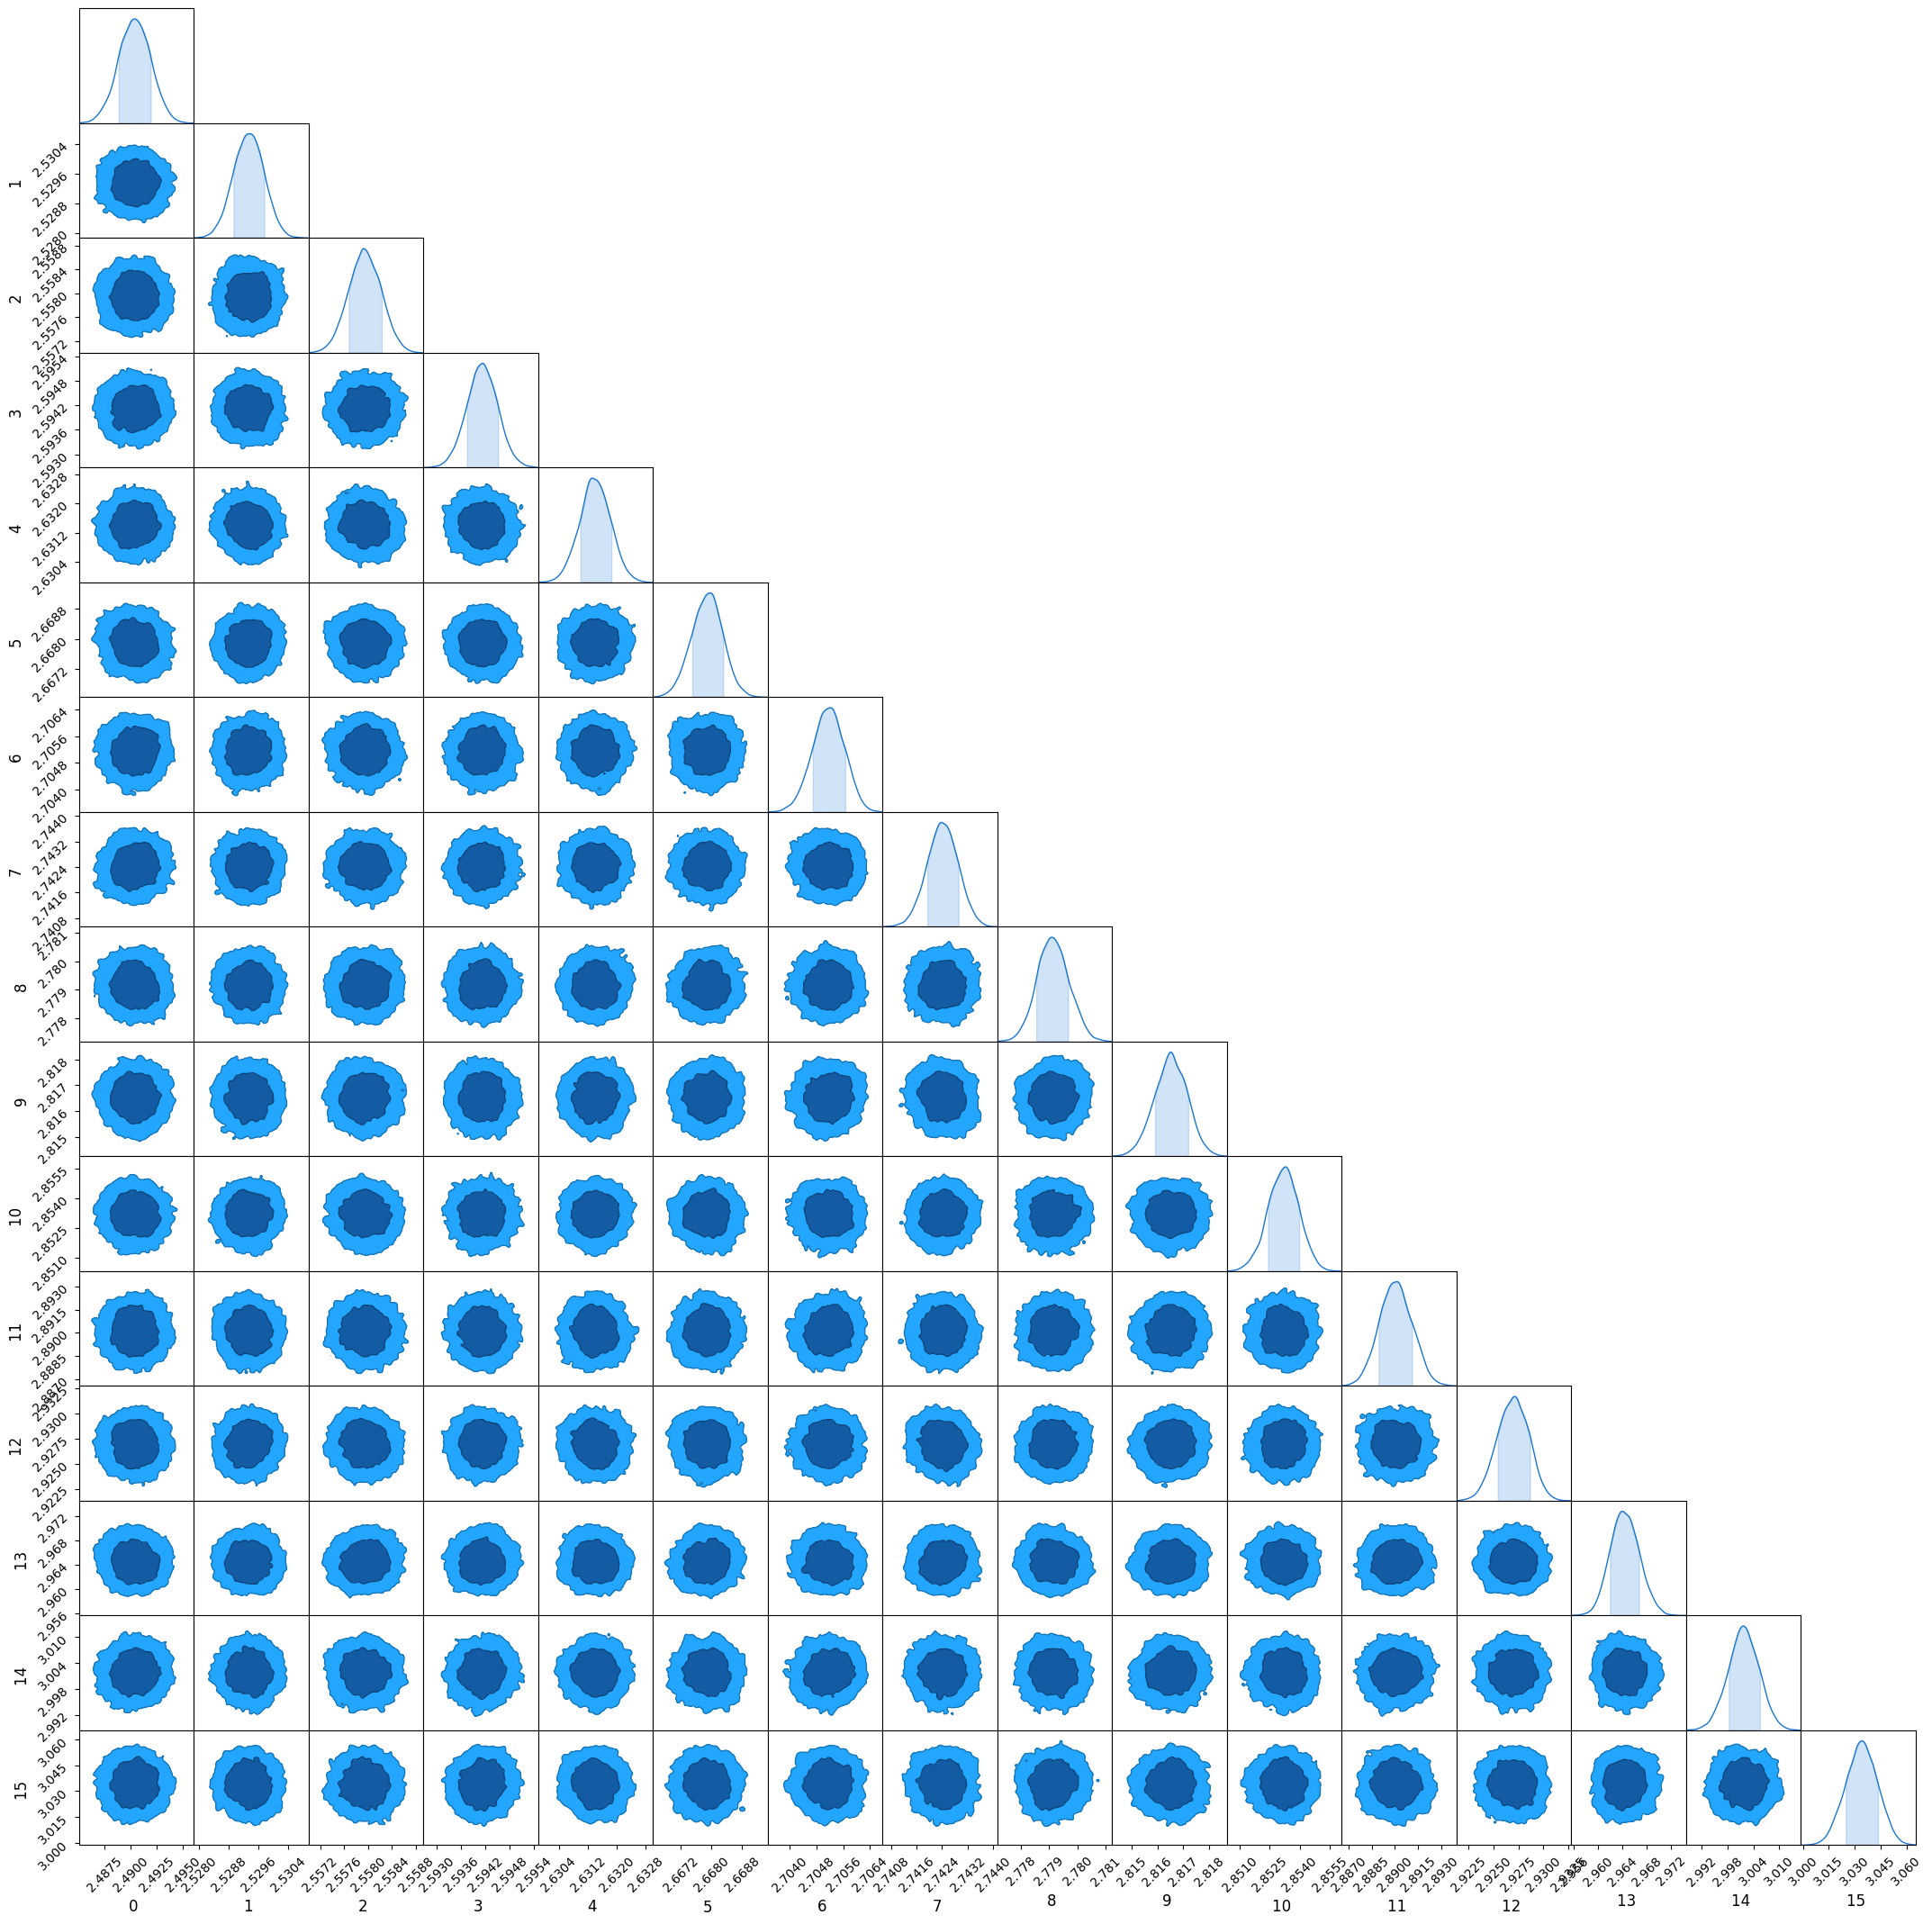

In [19]:
chain = sampler.get_chain(flat=True)
c = ChainConsumer()
chain = chain[200000:]
c.add_chain(chain)
_=c.plotter.plot()

In [20]:
# Generate the fiducial map and noise.
fidmap60, basemap = SM.foreground_gsma_nsidelo(nu=[60, 408])
noise = np.ones(len(fidmap60))*1.
data = fidmap60

# Set up the forward model.
Nreg = 16
mask_maps, inference_boundguess = NRI.mask_split(Nregions=Nreg)
model = partial(pix_forward_model_pl, nuarr=[60], base_map=basemap, masks=mask_maps)

# Set up the inference.
steps = 10000
nwalkers = 32
p0 = np.mean(chain, axis=0)
pos = p0*(1 + 1e-4*np.random.randn(nwalkers, Nreg))
priors = [[0.5, 5.0]]*Nreg
priors = np.array(priors)
sampler = EnsembleSampler(nwalkers, Nreg, NRI.log_posterior, 
                    args=(data, noise, model, priors))
_=sampler.run_mcmc(pos, steps, progress=True)

100%|█████████████████████████████████████| 10000/10000 [01:45<00:00, 94.80it/s]


In [98]:
# Generate the fiducial map and noise.
nuarr = np.linspace(50,100,6)
basemap = SM.foreground_gsma_nsidelo(nu=408)
fidmaps = SM.foreground_gsma_nsidelo(nu=nuarr)
noise = np.ones(len(fidmaps)*len(fidmaps[0]))*1.
data = fidmaps.flatten()

# Set up the forward model.
Nreg = 9
mask_maps, inference_boundguess = NRI.mask_split(Nregions=Nreg)
model = partial(pix_forward_model_pl, nuarr=nuarr, base_map=basemap, masks=mask_maps)

# Set up the inference.
steps = 10000
nwalkers = 32
p0 = np.mean(chain, axis=0)
pos = p0*(1 + 1e-4*np.random.randn(nwalkers, Nreg))
priors = [[0.5, 5.0]]*Nreg
priors = np.array(priors)
sampler = EnsembleSampler(nwalkers, Nreg, NRI.log_posterior, 
                    args=(data, noise, model, priors))
_=sampler.run_mcmc(pos, steps, progress=True)

100%|█████████████████████████████████████| 10000/10000 [06:46<00:00, 24.60it/s]


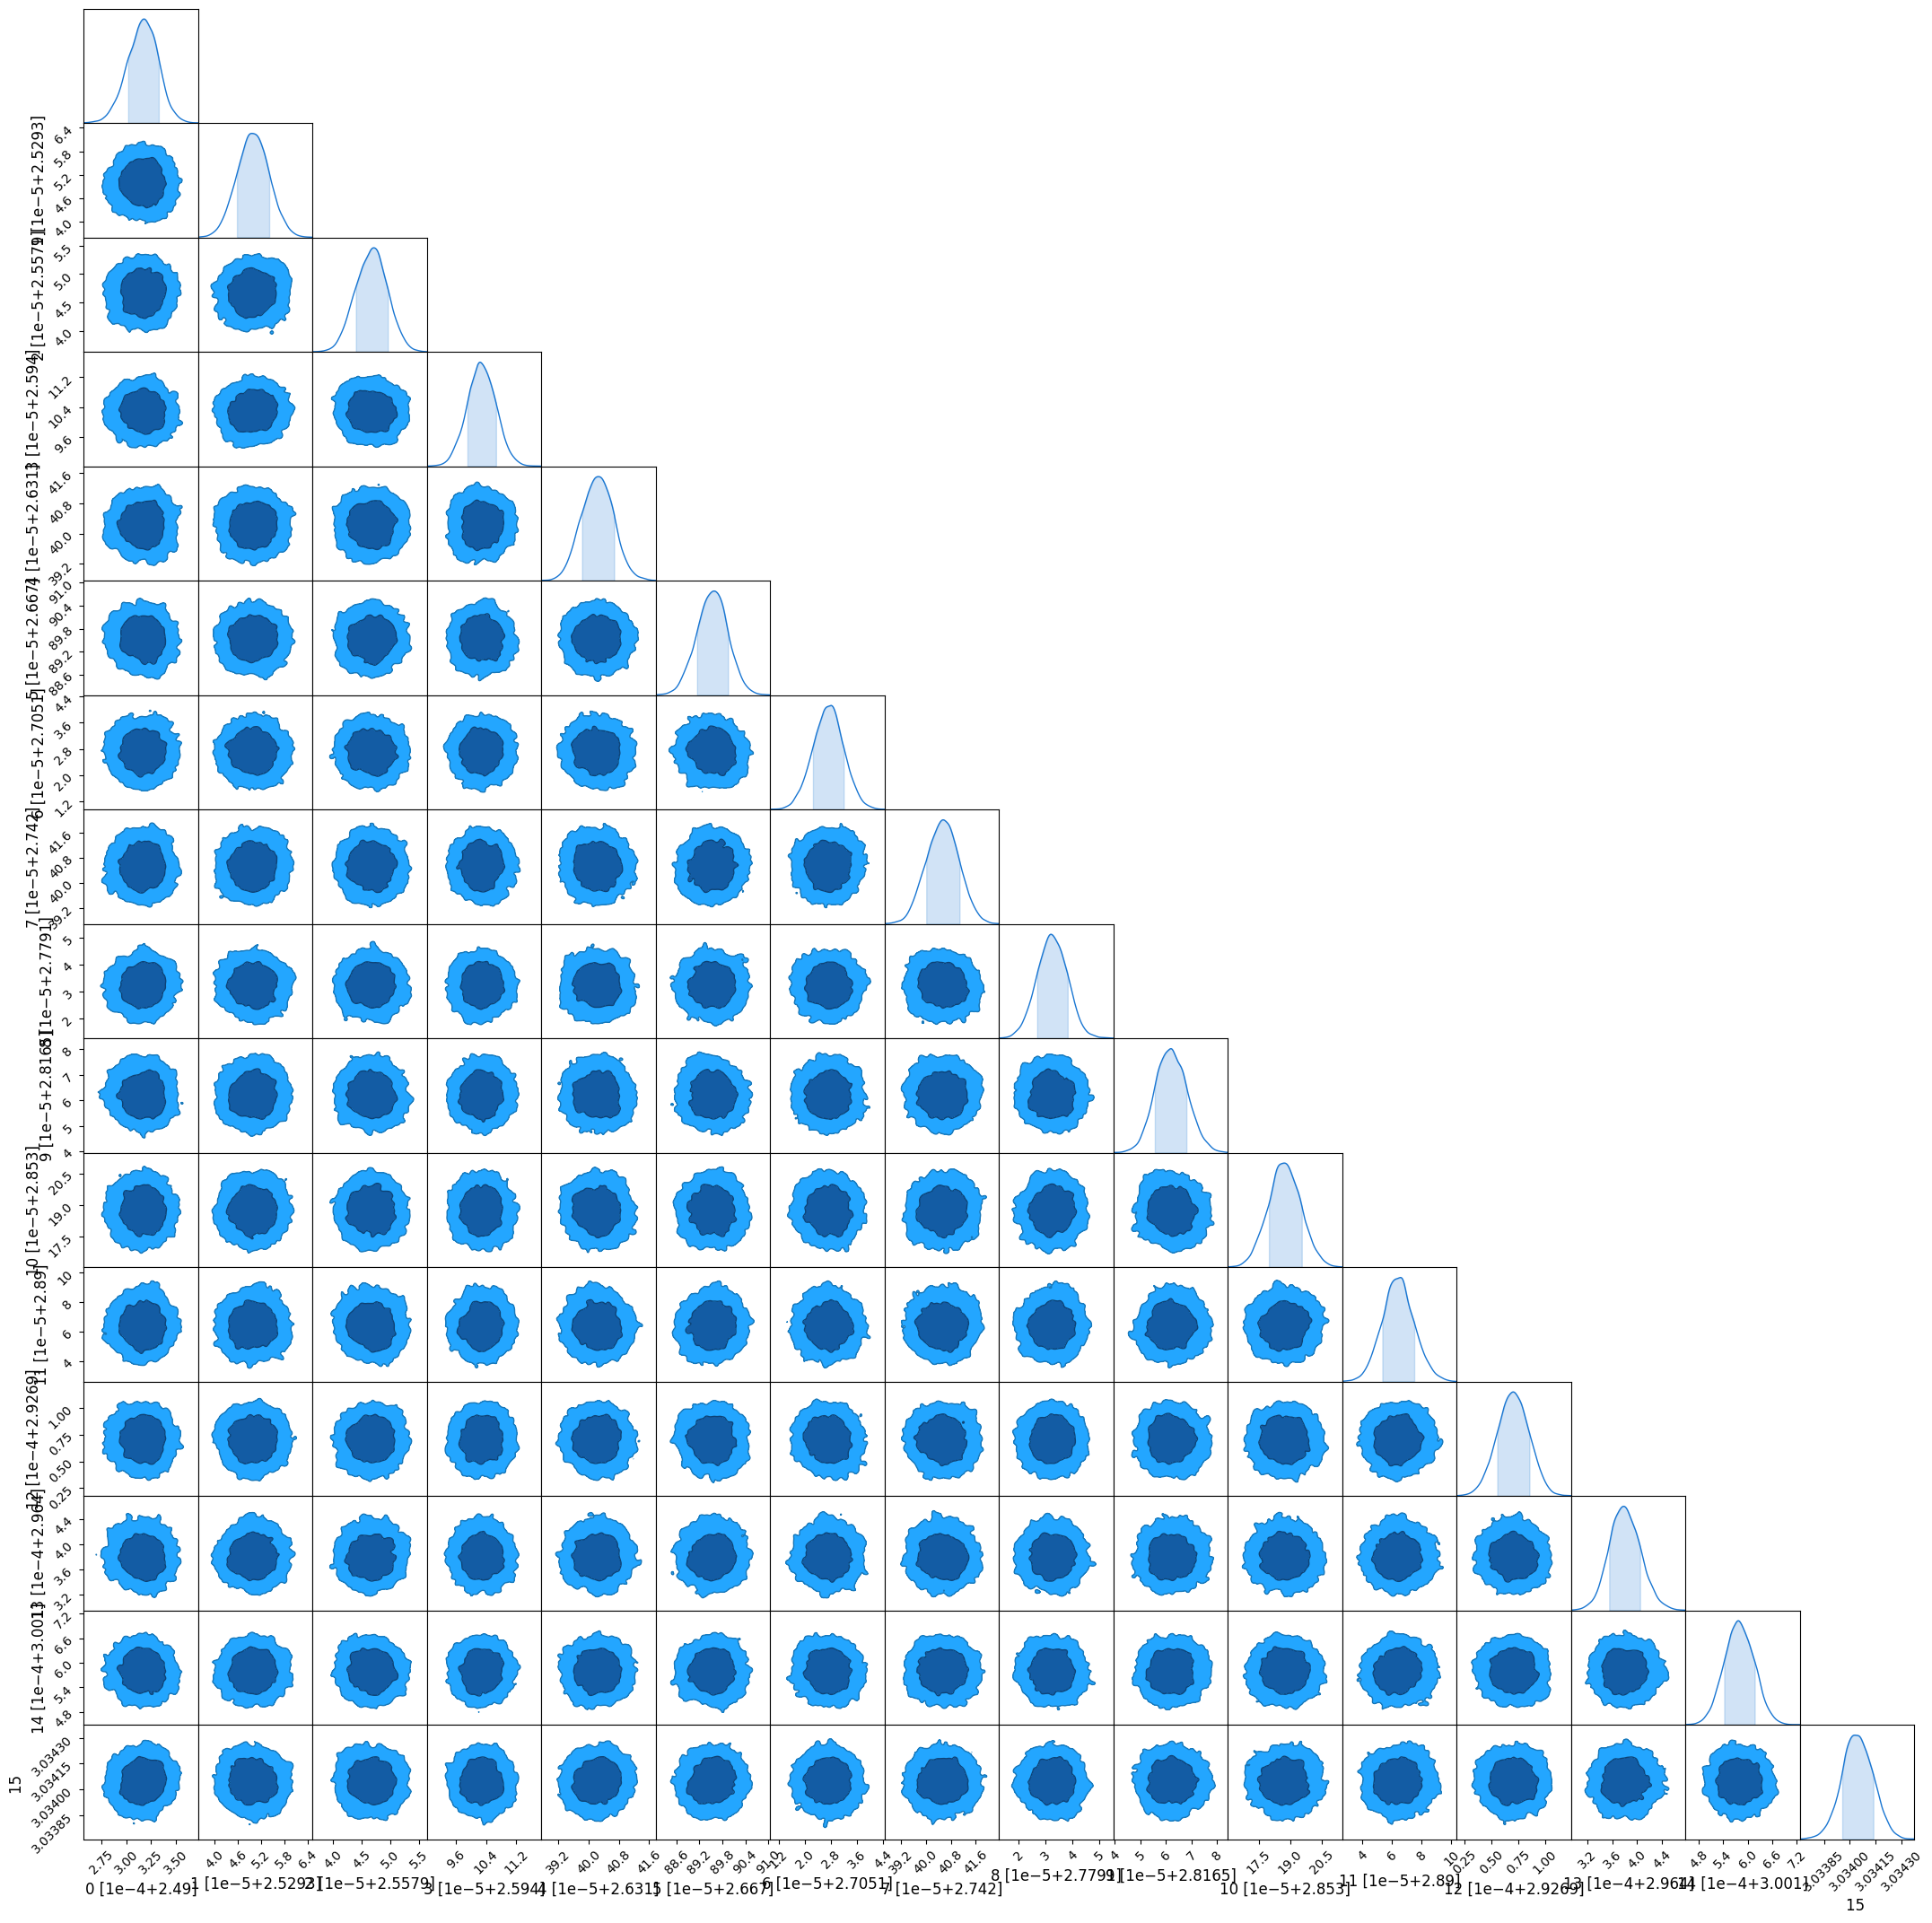

In [21]:
chain = sampler.get_chain(flat=True)
c = ChainConsumer()
chain = chain[200000:]
c.add_chain(chain)
_=c.plotter.plot()

## Does degrading the GSMA further increase the errors?
Let's try doing the same kinds of things with Nside=8.

In [8]:
# Generate the fiducial map and noise.
fidmap60, basemap = SM.foreground_gsma_nsidelo(nu=[60, 408], nside=8)
noise = np.ones(len(fidmap60))*10.
data = fidmap60

# Set up the forward model.
Nreg = 9
mask_maps, inference_boundguess = NRI.mask_split(Nregions=Nreg, nside=8)
model = partial(pix_forward_model_pl, nuarr=[60], base_map=basemap, masks=mask_maps)

# Set up the inference.
steps = 10000
nwalkers = 32
p0 = np.mean(inference_boundguess, axis=1)
pos = p0*(1 + 1e-4*np.random.randn(nwalkers, Nreg))
priors = [[0.5, 5.0]]*Nreg
priors = np.array(priors)
sampler = EnsembleSampler(nwalkers, Nreg, NRI.log_posterior, 
                    args=(data, noise, model, priors))
_=sampler.run_mcmc(pos, steps, progress=True)

100%|████████████████████████████████████| 10000/10000 [01:28<00:00, 112.60it/s]


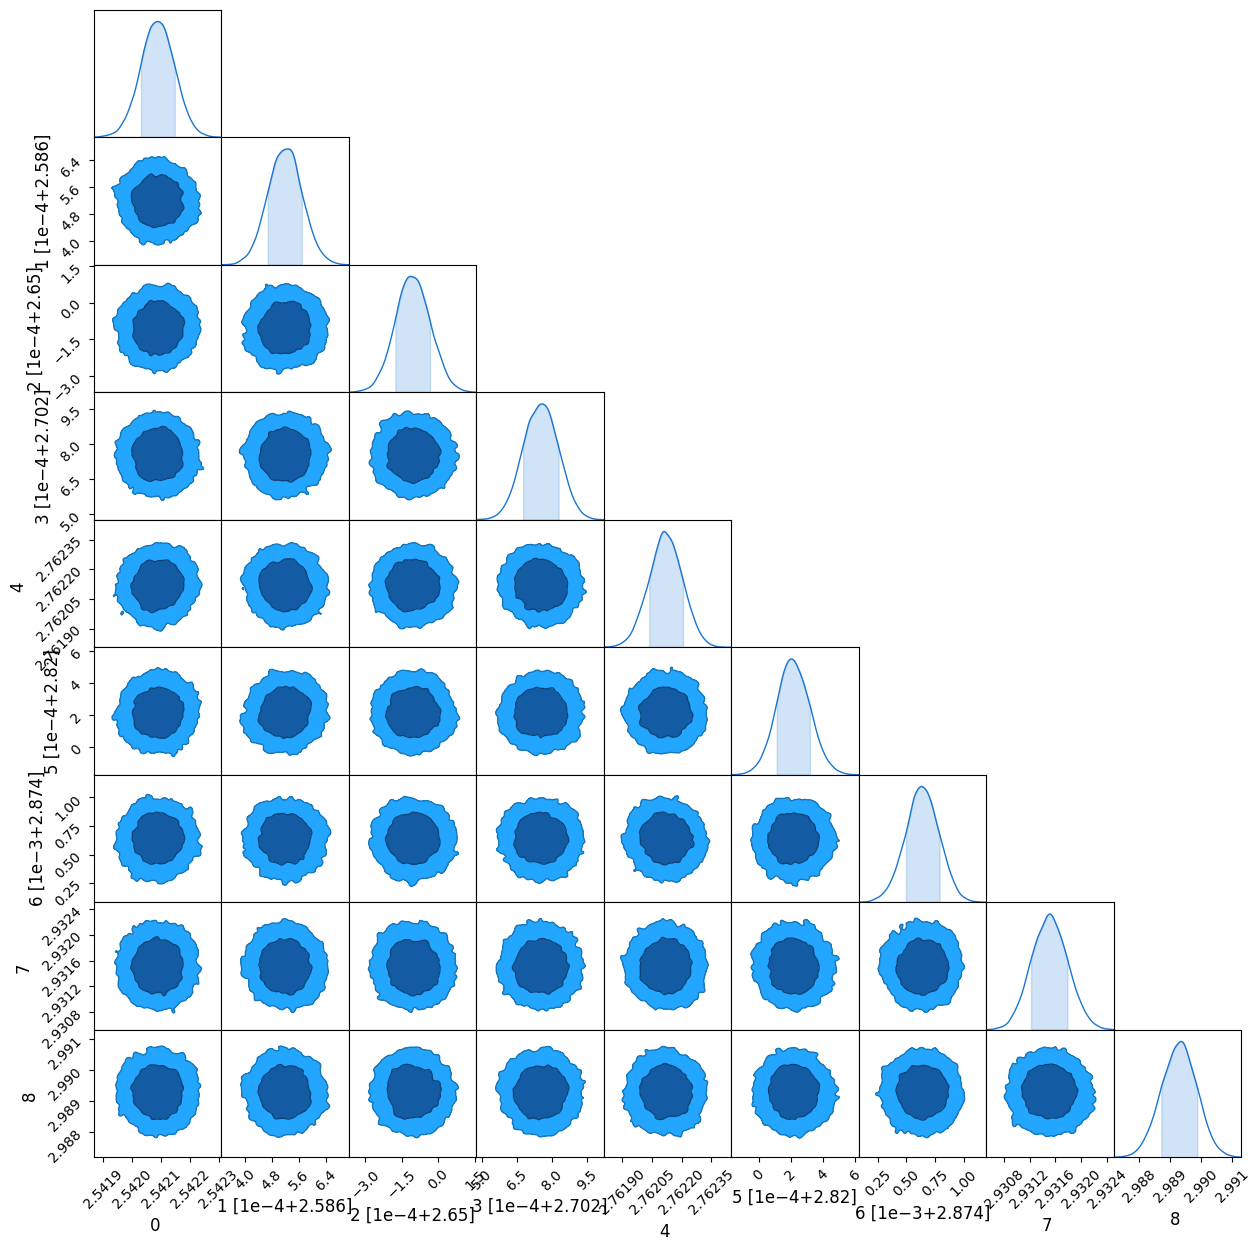

In [9]:
chain = sampler.get_chain(flat=True)
c = ChainConsumer()
chain = chain[200000:]
c.add_chain(chain)
_=c.plotter.plot()

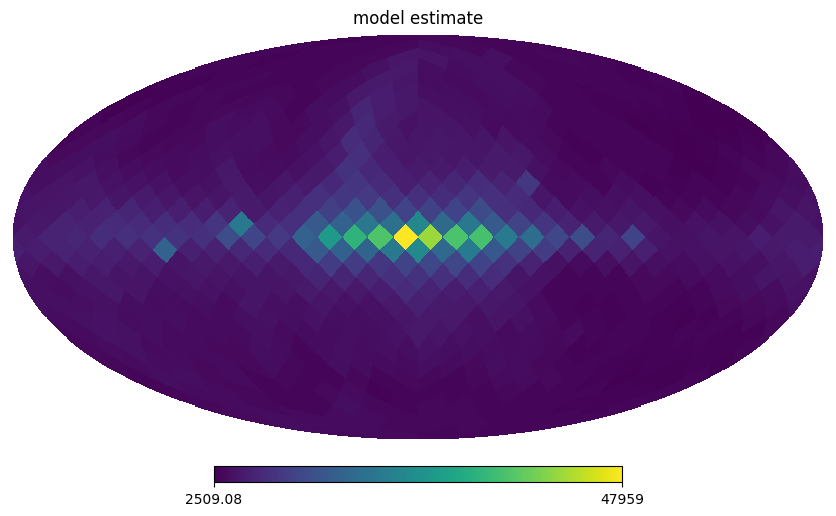

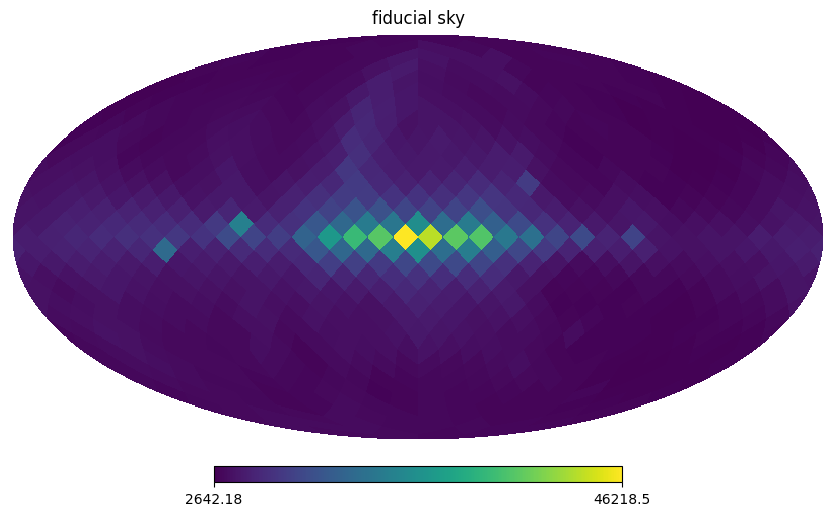

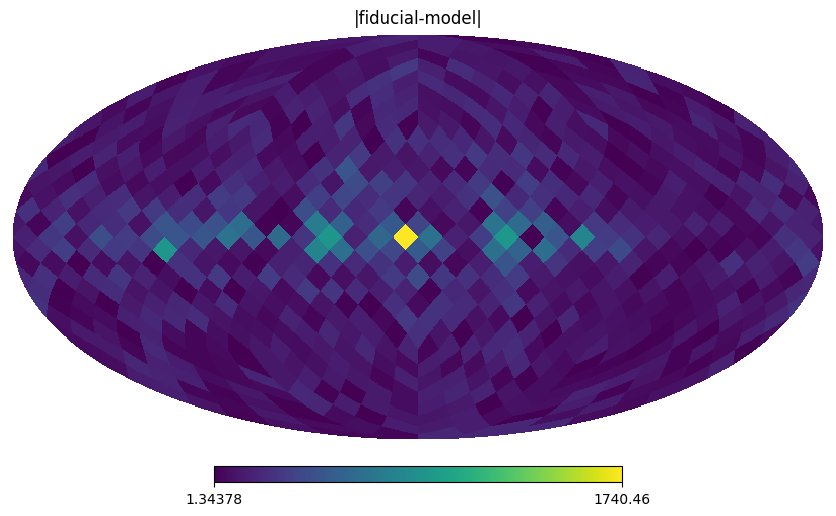

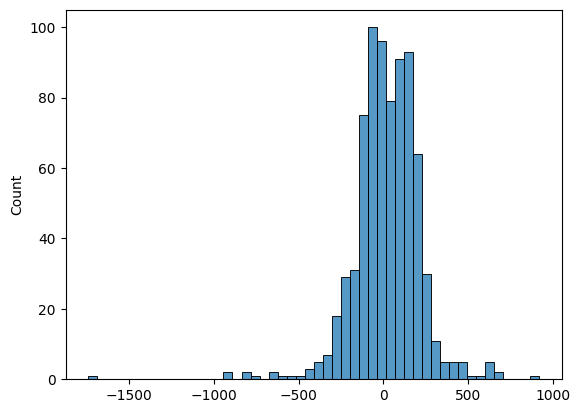

In [12]:
visualise_fgs_1(chain, Nreg, fidmap60)

#### Now check out errors from observational inference.

Loaded chain of orginal shape (300000, 32, 9)
Plotting chain of shape (800000, 9)


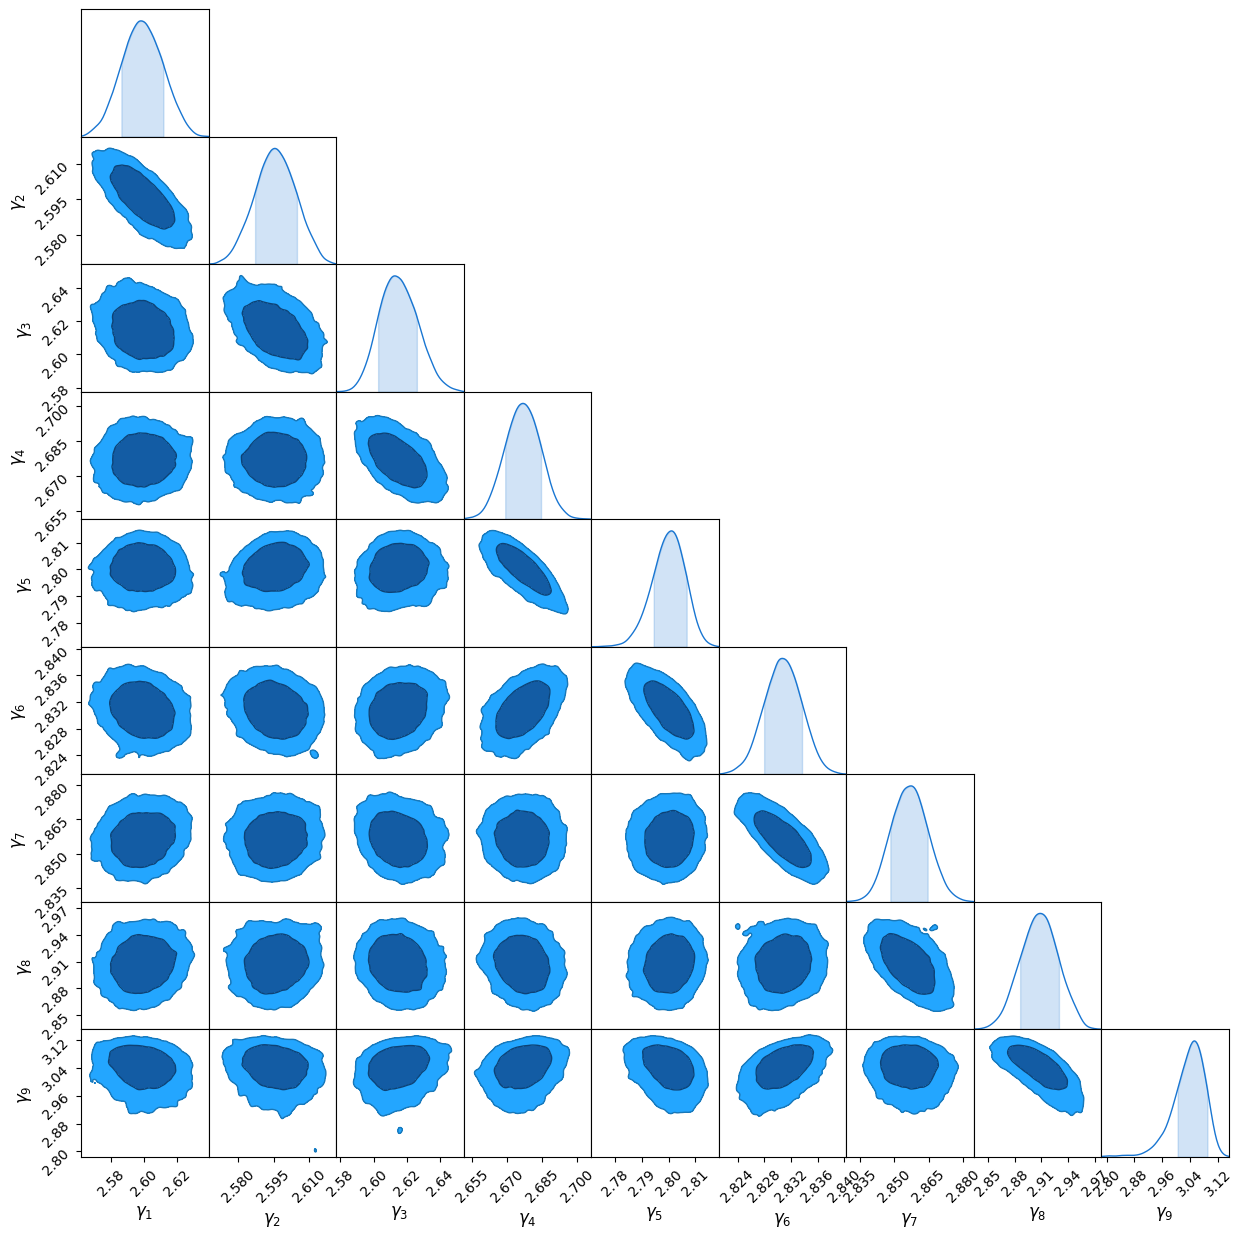

In [3]:
Nreg = 9
savename = f"{Nreg}reg_unoise_nside08"
chain_g = load_chain(savename, burn_in=50000, thin=10, end=-1, suffix="_2")
plot_chain(chain_g, walks=False)

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


calc_spherical_harmonic_matrix npix, nalm : 768 561


/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_34103/2139096420.py:66: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


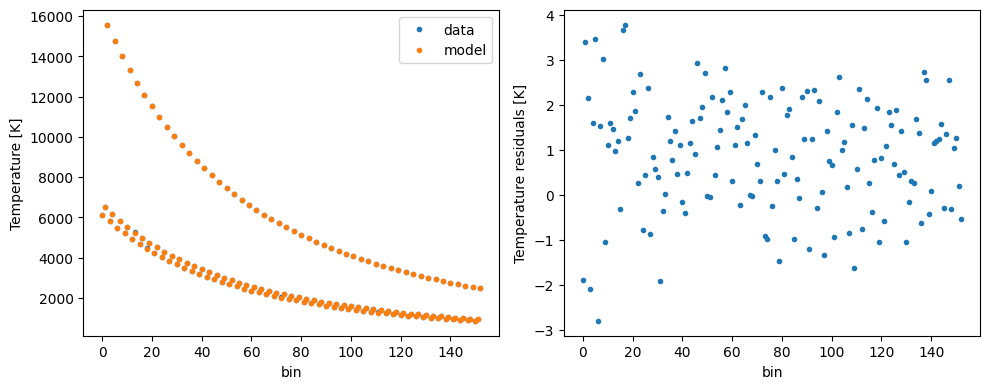

In [4]:
showcase_model_residuals(chain_g, Nreg, savename, stats='mean')

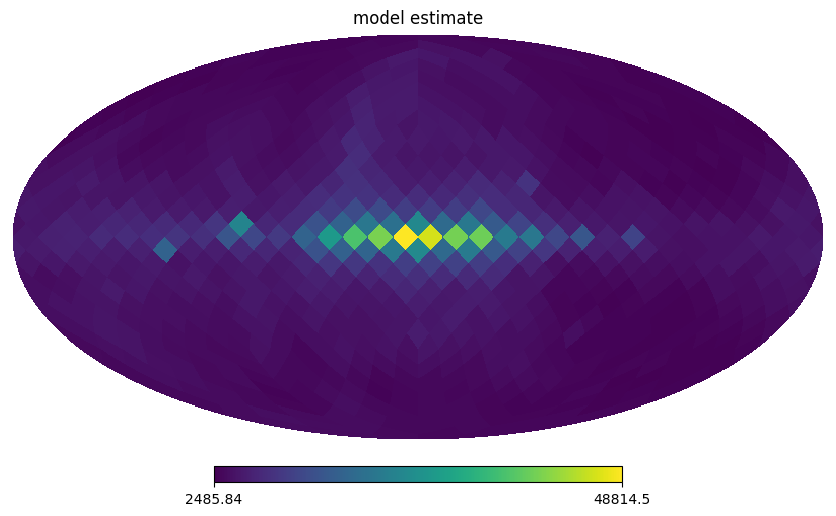

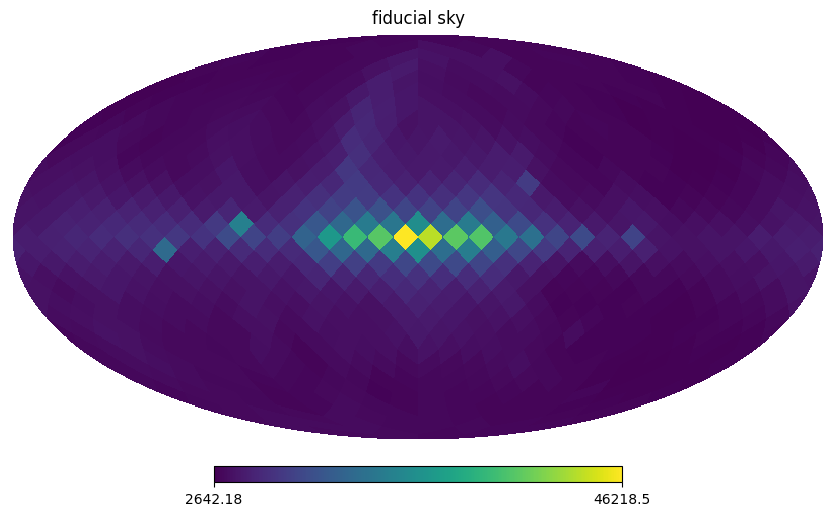

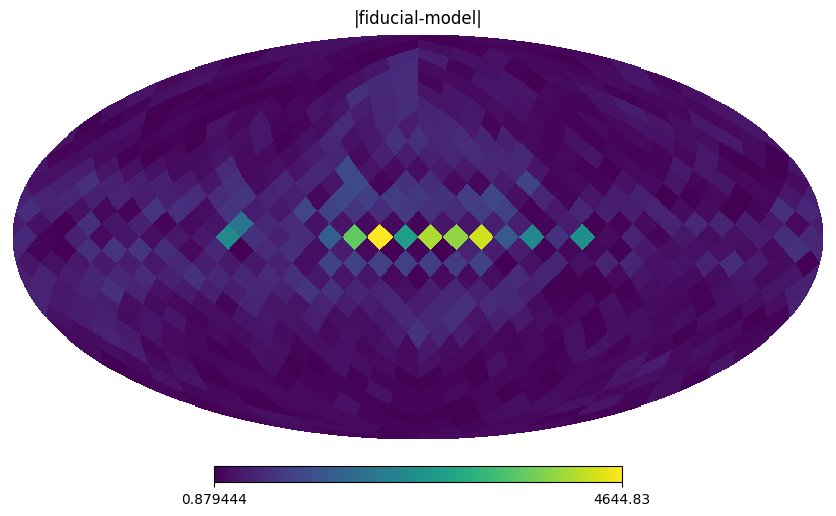

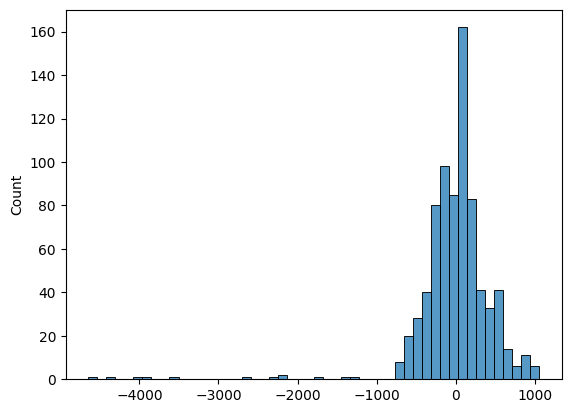

In [9]:
# The estimated foreground sky. 
visualise_fgs(chain_g, Nreg, nside=8)

Loaded chain of orginal shape (300000, 32, 9)
Plotting chain of shape (800000, 9)


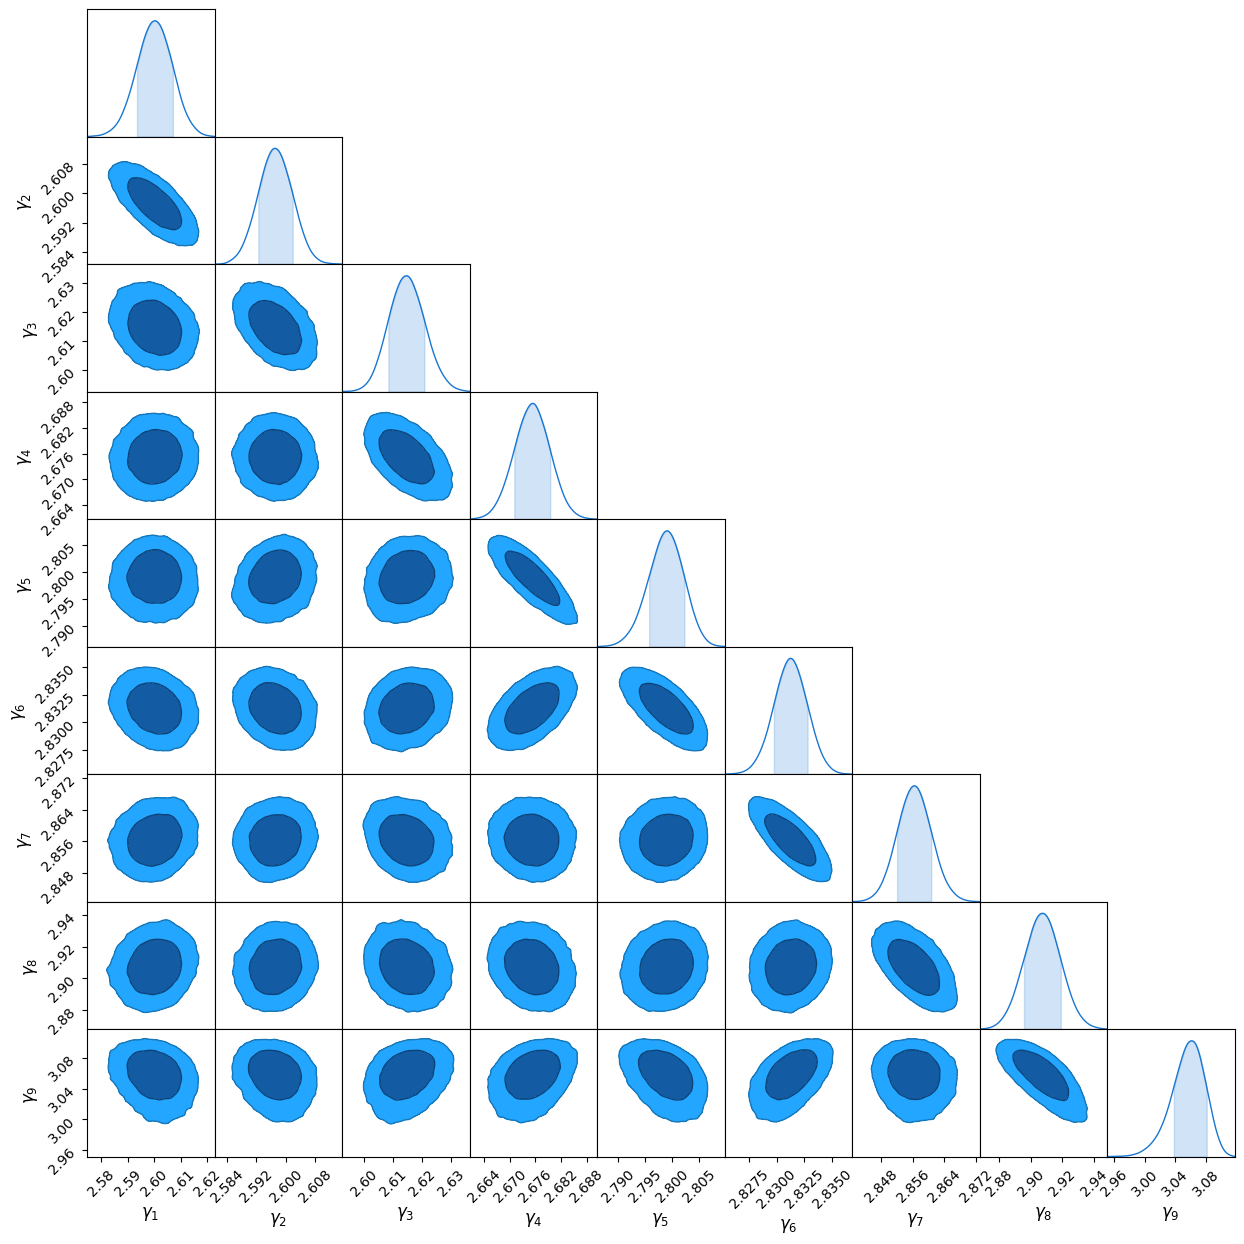

In [10]:
Nreg = 9
savename = f"{Nreg}reg_unoise_nside08_lonoise"
chain_g = load_chain(savename, burn_in=50000, thin=10, end=-1, suffix="_2")
plot_chain(chain_g, walks=False)

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


calc_spherical_harmonic_matrix npix, nalm : 768 561


/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_34103/3458414692.py:70: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


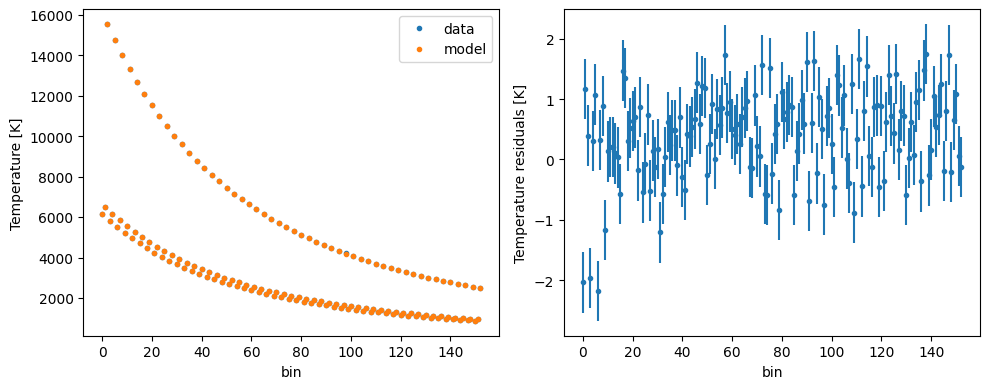

In [14]:
showcase_model_residuals(chain_g, Nreg, savename, stats='mean')

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


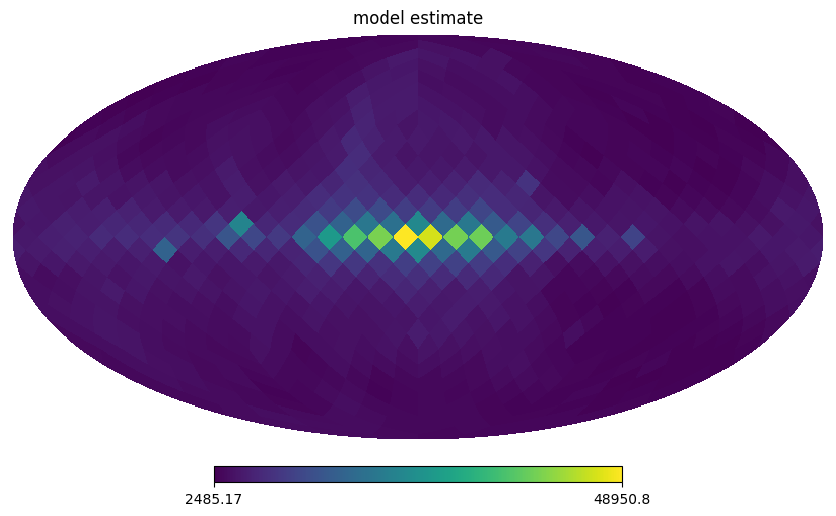

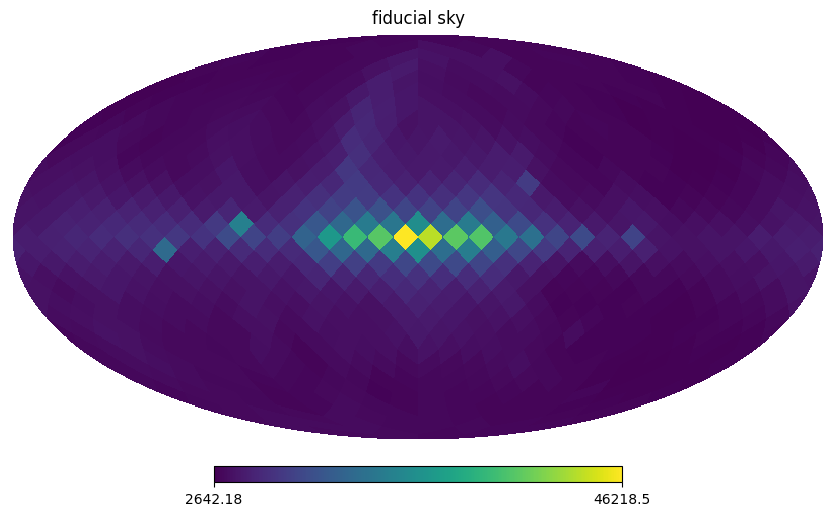

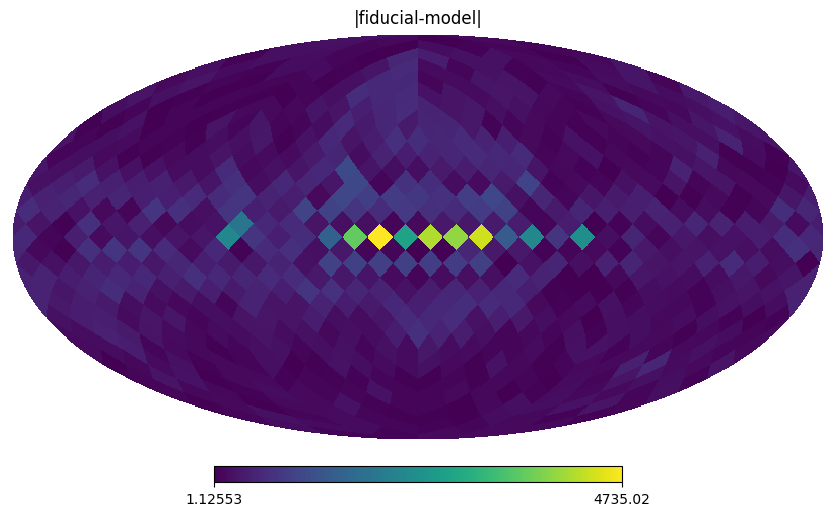

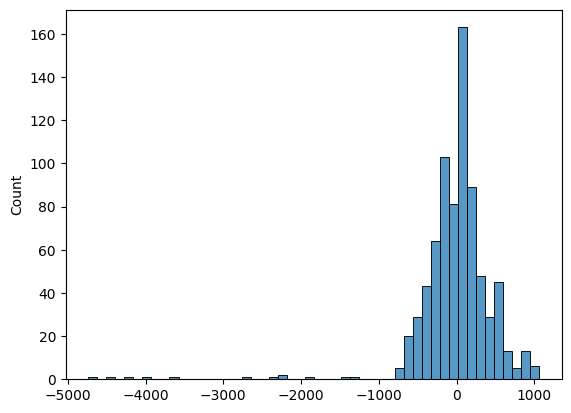

In [12]:
# The estimated foreground sky. 
visualise_fgs(chain_g, Nreg, nside=8)

Loaded chain of orginal shape (600000, 32, 9)
Plotting chain of shape (1760000, 9)


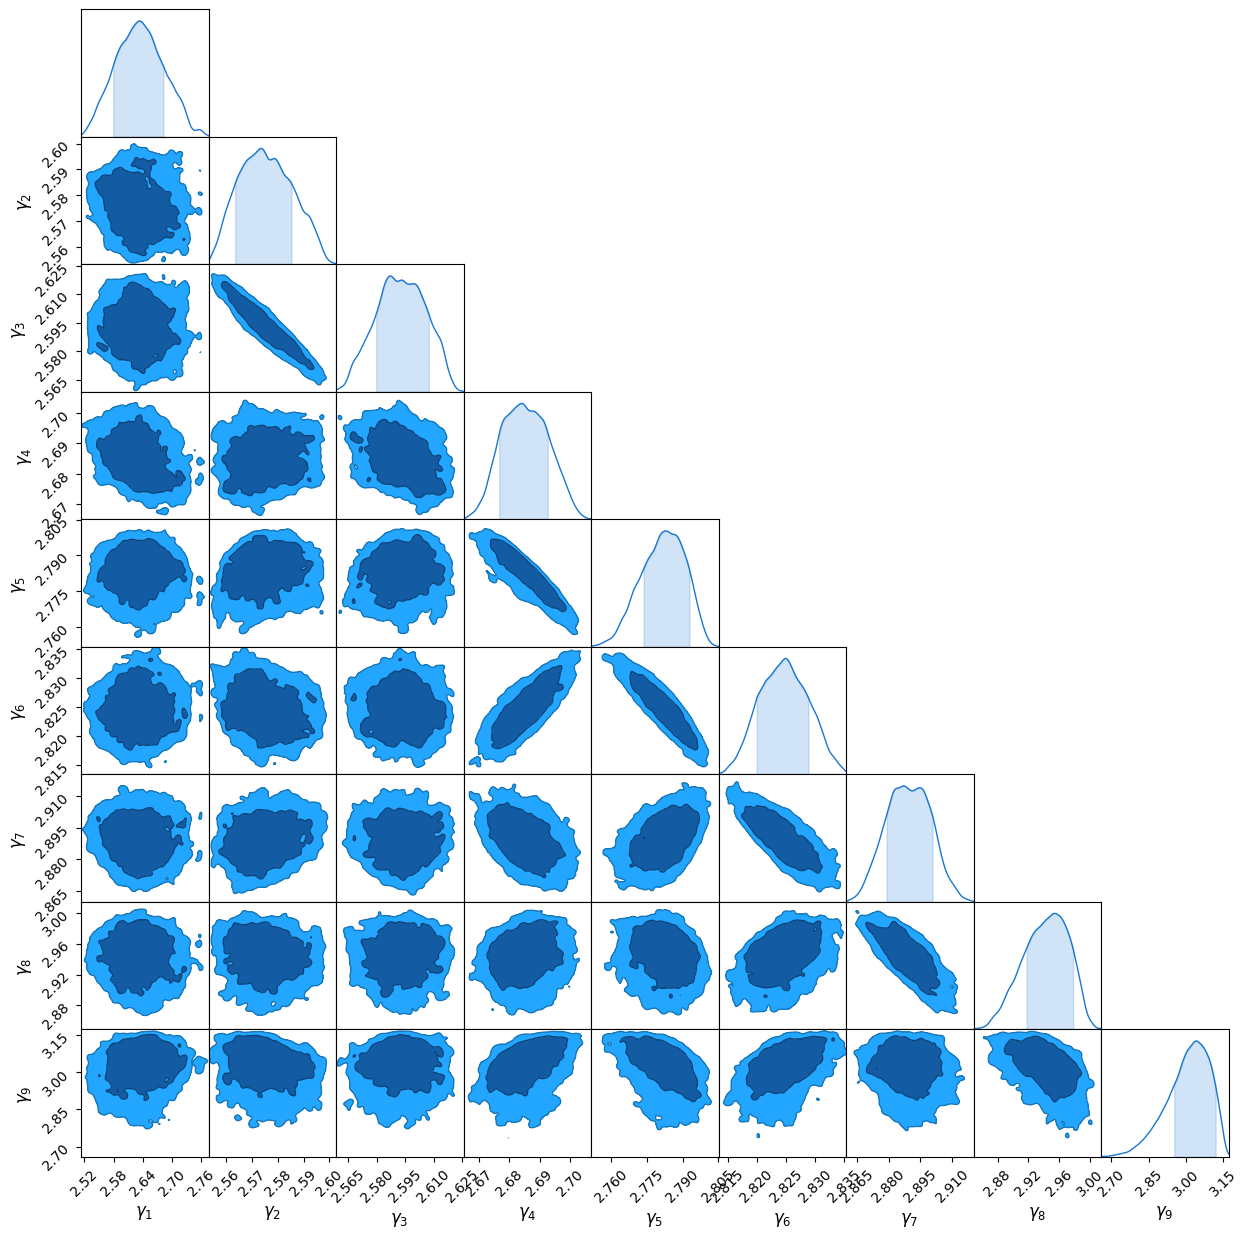

In [25]:
Nreg = 9
savename = f"{Nreg}reg_unoise_lonoise"
chain_g = load_chain(savename, burn_in=50000, thin=10, end=-1, suffix="_2")
plot_chain(chain_g, walks=False)

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


calc_spherical_harmonic_matrix npix, nalm : 3072 561


/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_34103/3458414692.py:70: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


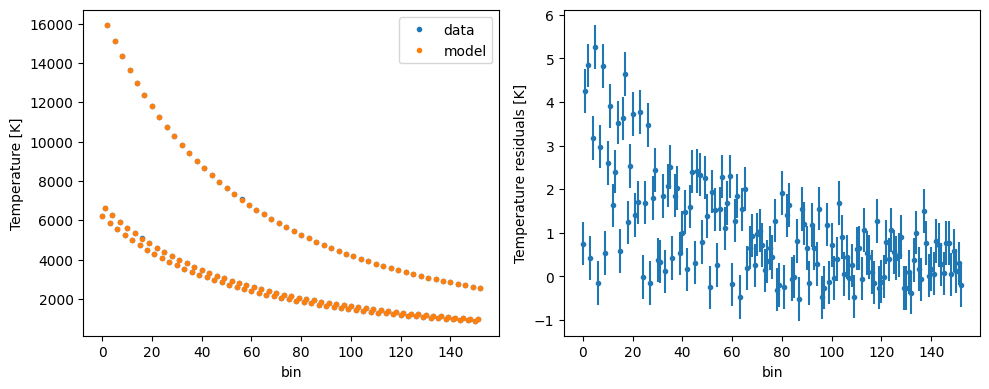

In [26]:
showcase_model_residuals(chain_g, Nreg, savename, stats='mean')

Loaded chain of orginal shape (600000, 32, 9)
Plotting chain of shape (1760000, 9)


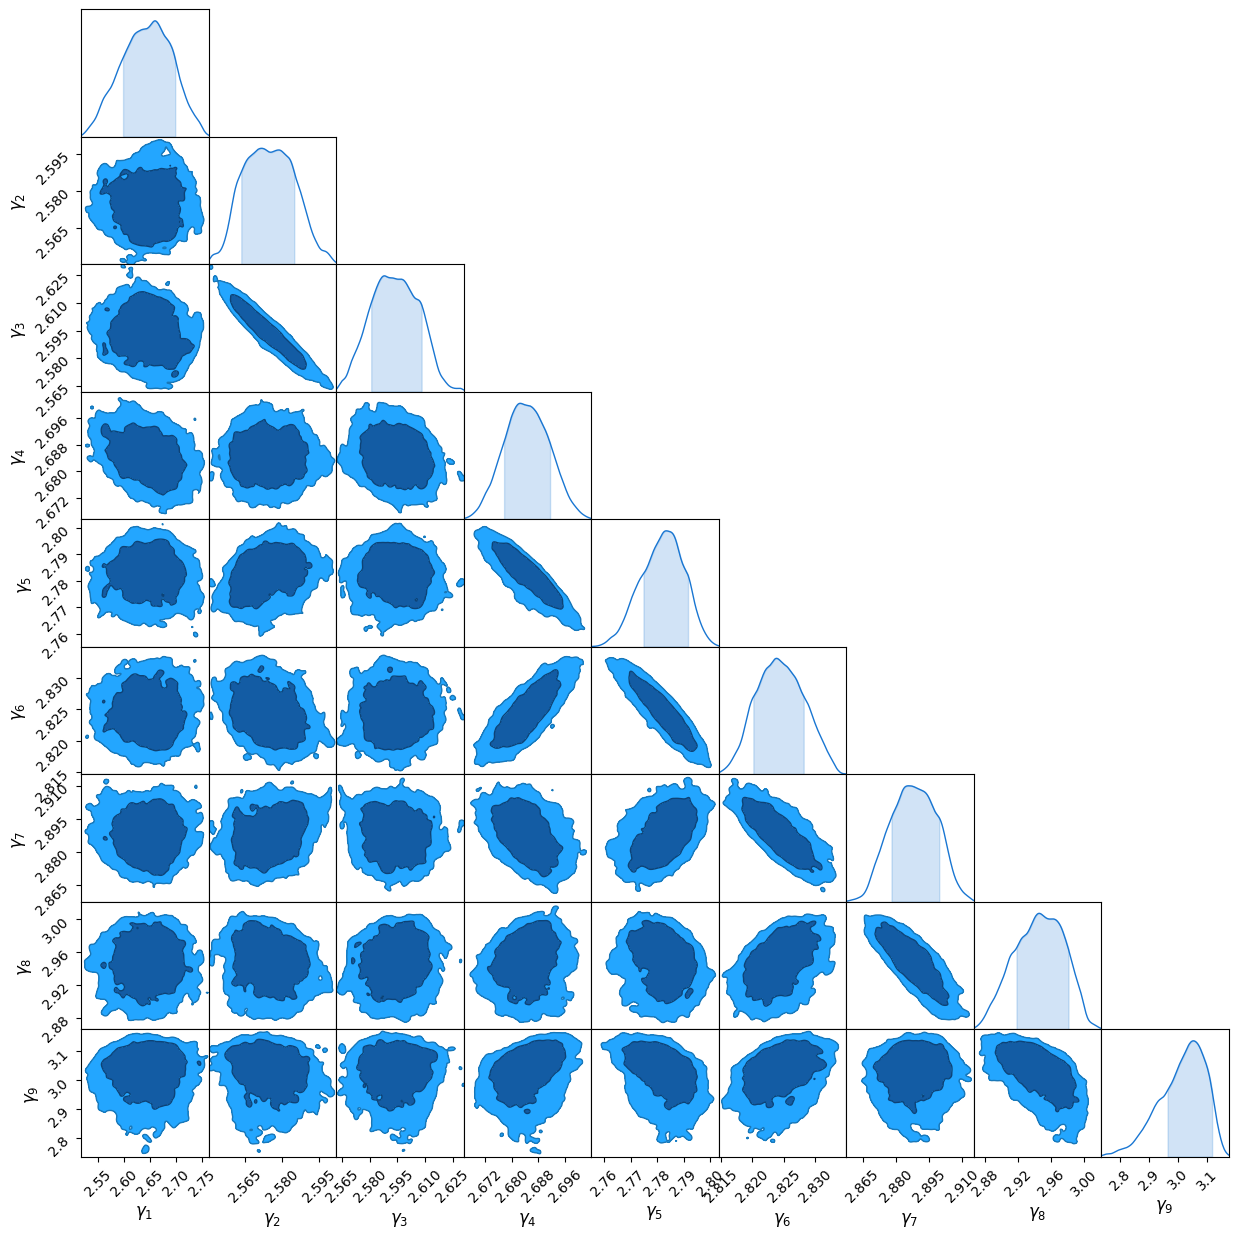

In [27]:
Nreg = 9
savename = f"{Nreg}reg_unoise_lmax64_lonoise"
chain_g = load_chain(savename, burn_in=50000, thin=10, end=-1, suffix="_2")
plot_chain(chain_g, walks=False)

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


calc_spherical_harmonic_matrix npix, nalm : 3072 2145


/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_34103/3458414692.py:70: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


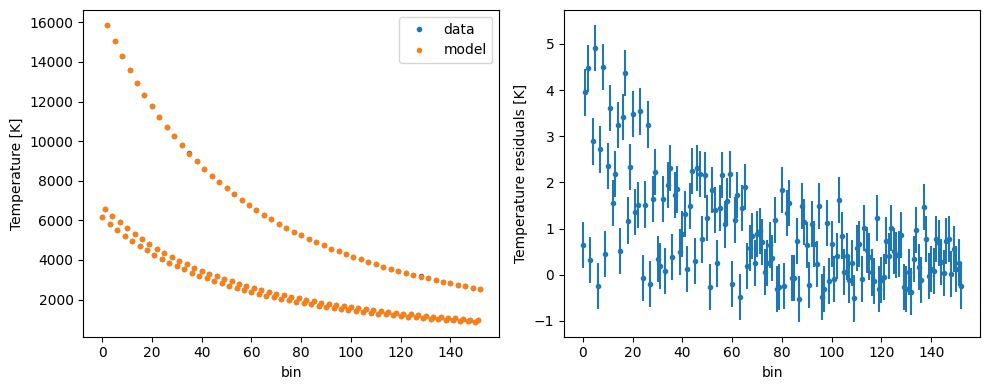

In [31]:
showcase_model_residuals(chain_g, Nreg, savename, stats='mean')